<a href="https://colab.research.google.com/github/bliits/Fetal_ECG_Extraction/blob/main/Fetal_ECG_extraction_and_arrhythmia_prediction_from_abdominal_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The problem of fetal illness during labor became a really serious problem in last years. It leads to different mutations, artefacts or even lethal end for the fetus. According to that, fetal ECG extraction and pathology detection are necessery and important part of fetus health analysis.

In last years scientists have created a lot of different methods to monitoring fetus health state. But, the most common method with best accuracy is non-invasive ECG analysis (it's a method where specialists measure abdominal signals and use them to extract fetal ECG). So, in this work, we'll use exactly abdominal signals to detect and extract fetal ECG signal.

However, there are many non-invasive methods for extracting the fetal ECG signal. In general, there are two main classes: adaptive and non-adaptive methods.

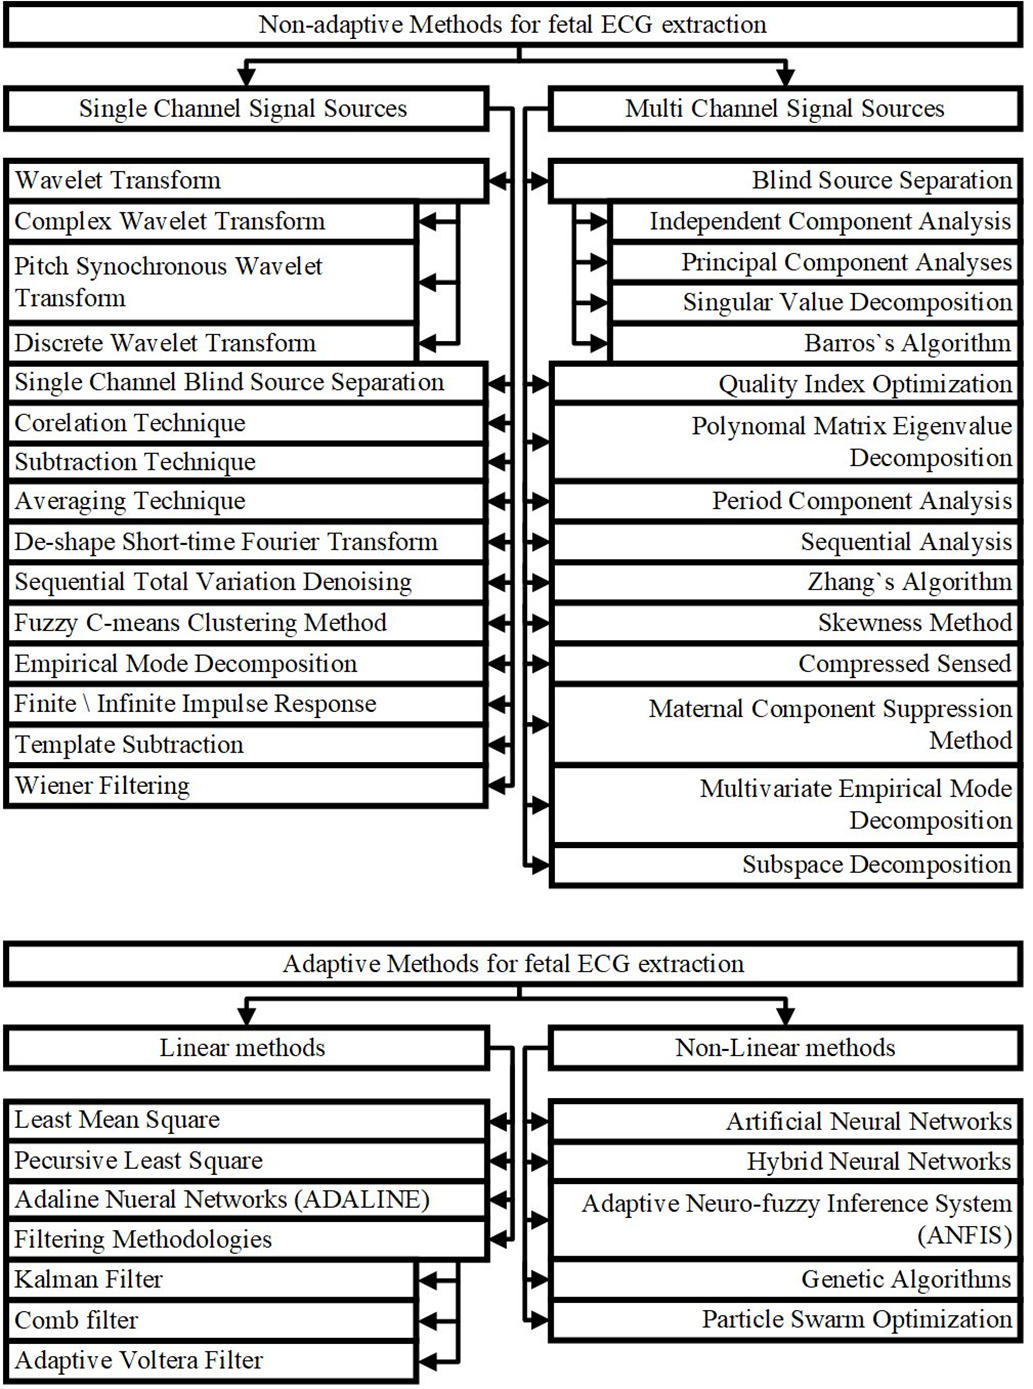

An adaptive method (or filter) is a filter which has the ability to self-adjust the filter coefficients according to an optimized training algorithm which is driven by a back propagated error signal. Adaptive filters are used in noise cancellation to remove the noise adaptively from a signal and to improve the signal to noise ratio.

The technique of non adaptive methods is the elimination of unwanted signals to obtain the fECG signal without system adaptation. So, this methods use only abdominal signals to extract fECG signal.

According to main task - the best decision is to combine non-adaptive method with adaptive filter. The main algorithm will be presented in the following image.

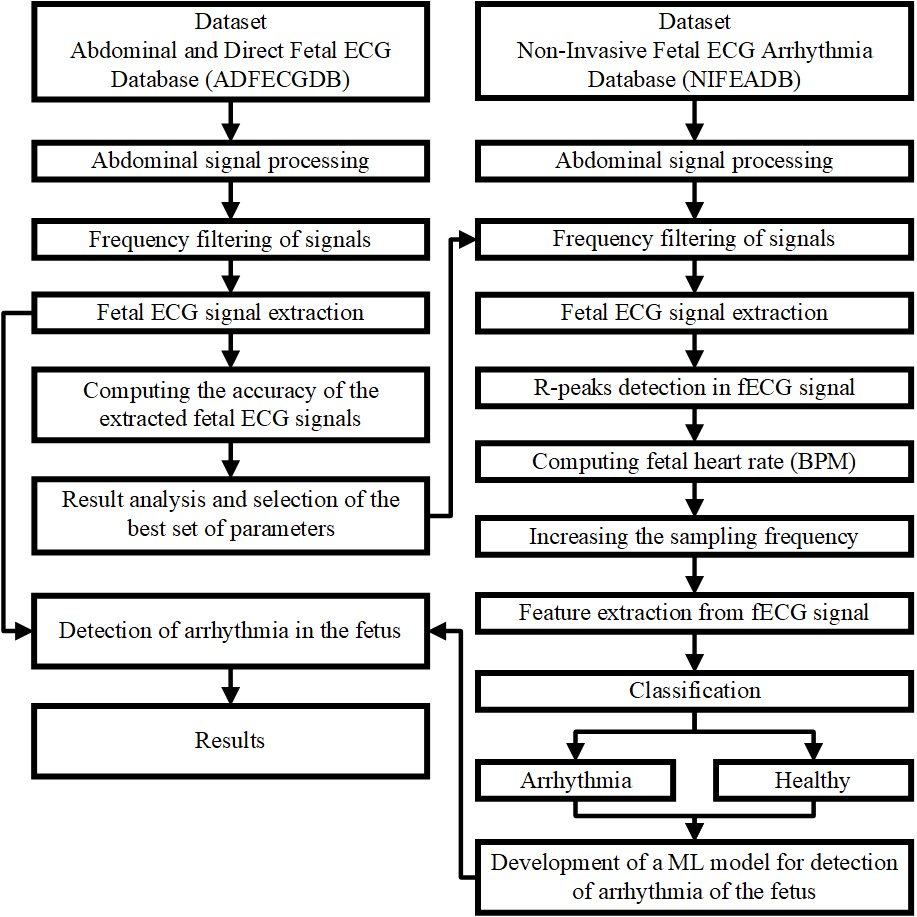

# Chapter 1. Fetal ECG signal extraction

More detailed algorithm of the first part presented in the following image.

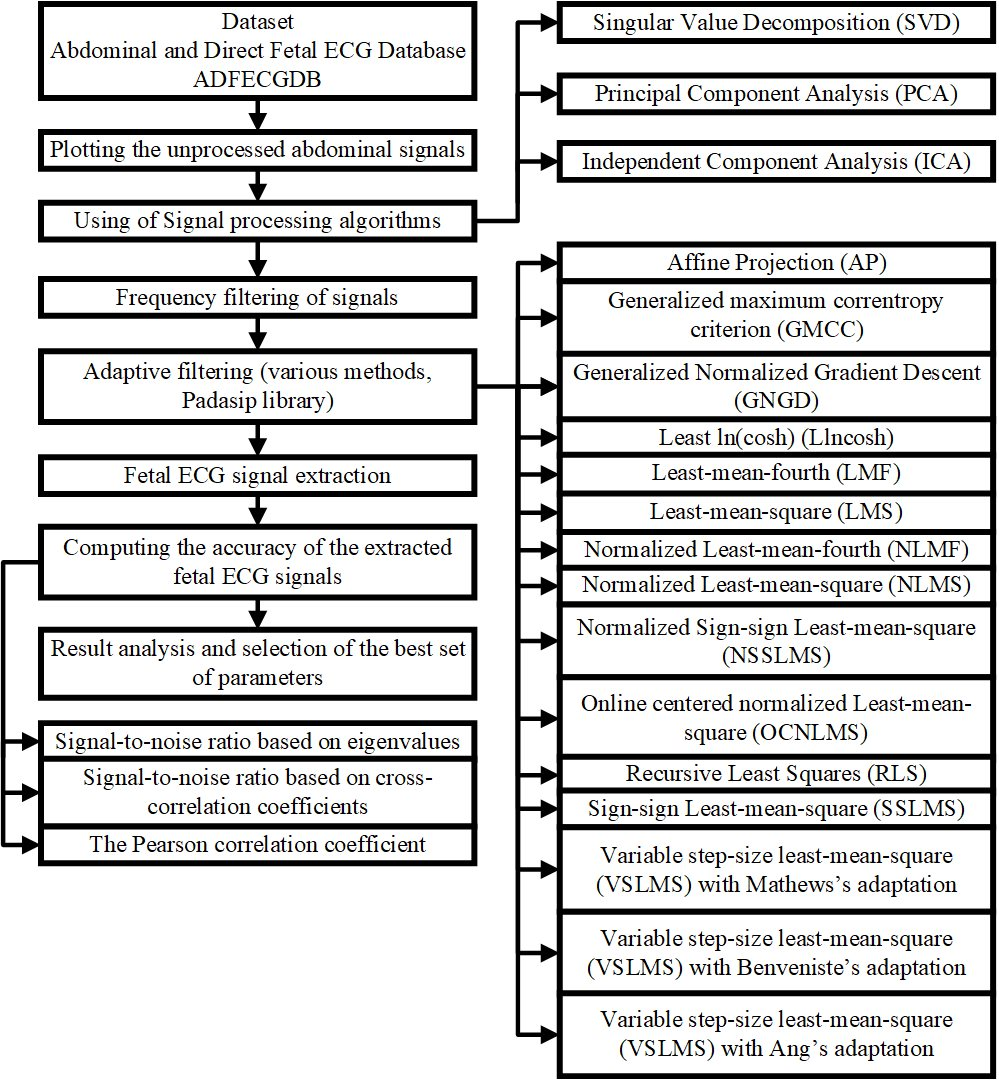

First of all, we have to find best combination of decomposition method and adaptive filter. One of the possible solutions is computing accuracy of extracted signal to each combination and compate them all. But we need open-source database with "reference" (or Invasive or Direct) signal to compute accuracy parameters (SNR and Pearson coeffs). Due to this requirement - the best database is "Abdominal and Direct Fetal ECG Database".

As we talked earlier - we should combine different decomposition methods and adaptive filters to find the best combination (with highest accuracy). According to last years progression in fetal ECG extraction, the best combinations of decomposition methods are:
1.   FastICA;
2.   PCA;
3.   PCA + FastICA;
4.   SVD+FastICA.

All current results will be summarized in dataFrame "main_DataFrame_1", which will include accuracy coefficients for each patient\adaprive filter\decomposition method.

In [1]:
# connection to google drive directory
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install padasip
!pip install pyedflib

In [ ]:
##################### part 1 #####################

from pyedflib import highlevel # edf reader library
import os
import re
import pandas as pd
from sklearn.decomposition import SparsePCA, FastICA, TruncatedSVD
import numpy as np
import padasip as pa
import scipy
from scipy.stats import pearsonr
from scipy import signal
import math


# function to search learning rate of adaptive filter
def gradient_search(gradient, adaptive_filt, start, learn_rate, n_iter,
                    coef_1, coef_2,
                    sig_1, sig_2, sig_3):
    mu_val = start
    # output parameters
    mu_val_prev = 0
    pears_max = 0
    signal_array = [0]
    for _ in range(n_iter):
        try:
            diff = learn_rate * gradient(mu_val)
            mu_val += diff
            if mu_val > 0:
                signal_ECG = (adaptive_filt(mu_val)).run(sig_1, sig_2)[1]
                # conditions to compute Pearson coefficient
                if math.isnan(sum(signal_ECG)) == False and abs(sum(signal_ECG)) < 1e10:
                    # second filtering
                    signal_ECG = scipy.signal.filtfilt(coef_1, coef_2, signal_ECG)
                    # computing the Pearson coefficient
                    pears_coef = pearsonr(sig_3, signal_ECG).statistic
                    # search the highest Pearson coeeficient for each filter
                    if pears_coef > pears_max:
                        pears_max = pears_coef
                        mu_val_prev = mu_val
                        signal_array = signal_ECG
        except ValueError: # ValueError case, when gradient(mu_val) cannot be computed
            mu_val += learn_rate
    return mu_val_prev, pears_max, signal_array

#################### step 1.1 ####################
# files path
file_path = "/content/drive/MyDrive/Colab Notebooks/abdominal-and-direct-fetal-ecg-database-1.0.0/"
# creation a list of csv files
full_dir_list = os.listdir(file_path)
mixed_list = ' '.join(full_dir_list)
edf_list = re.findall('\w+.edf', mixed_list)
edf_path_list = [file_path + s for s in edf_list]
# dataFrame with information about all patients
main_dataFrame_1 = pd.DataFrame()
# time + direct dictionaty
time_direct_dic = {"Abdominal_signal": [],
                   "Time": [],
                   "Direct_signal": []}
# first abdominal signal
for j in range(len(edf_path_list)):
    # edf information
    signals, signal_headers, header = highlevel.read_edf(edf_path_list[j])
    title_notes = pd.DataFrame(signal_headers)
    abd_col = title_notes['label']
    fs = title_notes['sample_frequency'][0] # sample frequency the same for each signal
    # time window to processing separate part of original signal
    time_param = 10 # seconds
    numb_count = (time_param*fs*np.linspace(0,int(np.floor(signals.shape[1]/fs/time_param)),
                                           int(np.floor(signals.shape[1]/fs/time_param))+1)).astype(int)
    for count_index in range(len(numb_count)-1):
        signal_cut = signals[:, numb_count[count_index]:numb_count[count_index+1]]
        # save notes \ titles about database in different variables
        abdominal_pd = pd.DataFrame(np.transpose(signal_cut), columns = abd_col)
        # convert DataFrame time object to nanoseconds scale
        time_pd = pd.DataFrame({'Time': abdominal_pd.index/fs})

        ##################### step 1.2 #####################
        # "empty" dataFrame with abdominal signals only
        abdominal_dataFrame = pd.DataFrame()
        # fill DataFrame by abdominal signals
        for ii in range(len(abd_col)):
            if abd_col[ii] in re.findall('Abd+\w+\d', ' '.join(abd_col)):
                abdominal_dataFrame = pd.concat([abdominal_dataFrame,
                                                 pd.DataFrame({abd_col[ii]: abdominal_pd[abd_col[ii]]})], axis = 1)
        # # "for" loop to compare accuracy of different analysis methods (PCA \ ICA \ ICA + SVD)
        coef_pd = pd.DataFrame()
        coef_filt_pd = pd.DataFrame()
        for i in range(4):
            if i == 0: # 1 - FastICA
                ica = FastICA(n_components=2, whiten="arbitrary-variance", random_state=42)
                rec_sig = ica.fit_transform(abdominal_dataFrame)
                title_n = "FastICA"
            if i == 1: # 2 - PCA
                pca = SparsePCA(n_components=2, random_state=42)
                rec_sig = pca.fit_transform(abdominal_dataFrame)
                title_n = "PCA"
            if i == 2: # 2 - PCA + FastICA
                pca = SparsePCA(n_components=2, random_state=42)
                PCA_data = pca.fit_transform(abdominal_dataFrame)
                # Compute ICA
                ica = FastICA(n_components=2, whiten="arbitrary-variance", random_state=42)
                rec_sig = ica.fit_transform(PCA_data)
                title_n = "PCA + FastICA"
            if i == 3: # 3 - SDA + FastICA
                svd = TruncatedSVD(n_components=2, n_iter=9, random_state=42)
                SVD_data = svd.fit_transform(abdominal_dataFrame)
                # Compute ICA
                ica = FastICA(n_components=2, whiten="arbitrary-variance", random_state=42)
                rec_sig = ica.fit_transform(SVD_data)
                title_n = "SVD + FastICA"
            # highpass filter
            b, a = scipy.signal.butter(1, 1e-2, 'highpass')
            # empty filtered reconstracted signal
            filt_rec_sig = np.zeros([len(rec_sig), 2])
            # filtering of reconstructed signals
            filt_rec_sig[:, 0] = scipy.signal.filtfilt(b, a, rec_sig[:, 0])
            filt_rec_sig[:, 1] = scipy.signal.filtfilt(b, a, rec_sig[:, 1])
            # normalizing
            filt_rec_sig[:, 0] = filt_rec_sig[:, 0] / max(filt_rec_sig[:, 0])
            filt_rec_sig[:, 1] = filt_rec_sig[:, 1] / max(filt_rec_sig[:, 1])
            # plot original and filtered+normalized signals
            time_scale_abd = time_pd.values.flatten()
            # new highpass filter for direct fetal signal
            b, a = scipy.signal.butter(5, 5e-3, 'highpass')
            # filtering
            filteredHighPass_dir = scipy.signal.filtfilt(b, a, (abdominal_pd[abd_col[0]]).astype(float))
            # normalizing
            filteredHighPass_dir = filteredHighPass_dir/max(filteredHighPass_dir)

            ##################### step 1.3 #####################
            # compare accuracy of different adaptive filters
            # dictionary with general information
            coef = {'Abdominal_signal': [],
                    'Filter_name': [],
                    'mu': [],
                    'Pears_Coef': [],
                    'Rec_Signal': []}
            # "for" loop to compute Pearson coefficients for different adap filters
            for jj in range(14):
                if jj == 0:    adap_filt = lambda mu_sear: pa.filters.FilterAP(n=4,order=4,mu=mu_sear,ifc=1e-3,w="random")
                elif jj == 1:  adap_filt = lambda mu_sear: pa.filters.FilterGMCC(n=4,mu=mu_sear,w="random")
                elif jj == 2:  adap_filt = lambda mu_sear: pa.filters.FilterGNGD(n=4,mu=mu_sear,w="random")
                elif jj == 3:  adap_filt = lambda mu_sear: pa.filters.FilterLlncosh(n=4,mu=mu_sear,lambd=0.1,w="random")
                elif jj == 4:  adap_filt = lambda mu_sear: pa.filters.FilterLMF(n=4,mu=mu_sear,w="random")
                elif jj == 5:  adap_filt = lambda mu_sear: pa.filters.FilterLMS(n=4,mu=mu_sear,w="random")
                elif jj == 6:  adap_filt = lambda mu_sear: pa.filters.FilterNLMF(n=4,mu=mu_sear,w="random")
                elif jj == 7:  adap_filt = lambda mu_sear: pa.filters.FilterNLMS(n=4,mu=mu_sear,w="random")
                elif jj == 8:  adap_filt = lambda mu_sear: pa.filters.FilterNSSLMS(n=4,mu=mu_sear,w="random")
                elif jj == 9:  adap_filt = lambda mu_sear: pa.filters.FilterOCNLMS(n=4,mu=mu_sear,w="random",mem=100)
                elif jj == 10: adap_filt = lambda mu_sear: pa.filters.FilterSSLMS(n=4,mu=mu_sear,w="random")
                elif jj == 11: adap_filt = lambda mu_sear: pa.filters.FilterVSLMS_Ang(n=4,mu=mu_sear,ro=1e-15,w="random")
                elif jj == 12: adap_filt = lambda mu_sear: pa.filters.FilterVSLMS_Benveniste(n=4,mu=mu_sear,ro=1e-15,w="random")
                elif jj == 13: adap_filt = lambda mu_sear: pa.filters.FilterVSLMS_Mathews(n=4,mu=mu_sear,ro=1e-15,w="random")
                # adaptive filtering + Pearson coefficient computing
                param_1, param_2, param_3 = gradient_search(gradient=lambda grad_mu:pearsonr(filteredHighPass_dir,
                                                                                              (adap_filt(grad_mu)).run(filt_rec_sig[:, 1],
                                                                                                                       abdominal_dataFrame.values)[1]).statistic,
                                                             adaptive_filt=adap_filt,
                                                             start=0,
                                                             learn_rate=1e-6,
                                                             n_iter=1000,
                                                             coef_1 = b, coef_2 = a,
                                                             sig_1 = filt_rec_sig[:, 1],
                                                             sig_2 = abdominal_dataFrame.values,
                                                             sig_3 = filteredHighPass_dir)
                # filling the dictionary with adaptive filters information
                coef['Abdominal_signal'].append(edf_list[j])
                coef['Filter_name'].append(adap_filt(param_1).kind)
                coef['mu'].append(param_1) # learning rate
                coef['Pears_Coef'].append(param_2) # Pearson coefficient
                coef['Rec_Signal'].append(param_3)

            ##################### step 1.4 #####################
            # convert dictionary to dataFrame
            coef_pd = pd.concat([coef_pd, pd.DataFrame(coef)], ignore_index = True)
            # some parameters to compute two kind of SNR
            t_max_arr = np.zeros(2)
            t_R_peak = 0
            t_extr_peak = []
            t_R_peak_array = []
            # dictionary with computed SNR
            coef = {'Decomposition': [],
                    'SNR_Eig': [],
                    'SNR_RMS': [],
                    'Filtered_signal': []}
            # new highpass filter
            b, a = scipy.signal.butter(1, 3e-2, 'highpass')
            for ii in range(i*14, 14+i*14):
                sigma = 0
                lamb = 0
                ECG_sig = [0]
                if len(coef_pd['Rec_Signal'][ii]) == len(filteredHighPass_dir):
                    # filtering + normalizing
                    f_HP = scipy.signal.filtfilt(b, a, coef_pd['Rec_Signal'][ii])
                    ECG_sig = f_HP/max(f_HP)
                    t_extr_peak.append(abdominal_pd[abd_col[0]][1])
                    # "for" loop to find R-peaks and extremes information
                    for jj in range(1, len(ECG_sig)-1):
                        if ECG_sig[jj] > ECG_sig[jj+1] and ECG_sig[jj] > ECG_sig[jj-1]:
                            if ECG_sig[jj] > 0.55:
                                t_R_peak = jj
                                t_R_peak_array.append(jj)
                            else:
                                t_max_arr[0] = t_max_arr[1]
                                t_max_arr[1] = jj
                                if t_max_arr[0] < t_R_peak and t_max_arr[1] > t_R_peak:
                                    t_extr_peak.append(t_max_arr[0])
                                    t_extr_peak.append(t_max_arr[1])
                    t_extr_peak.append(len(ECG_sig)-1)
                    if len(t_extr_peak) > 2:
                        # search number of samples in area around R-peaks
                        counter = np.zeros([len(t_extr_peak)])
                        # median filtering step
                        for aa in range(0, len(t_extr_peak), 2):
                            fecg_med = signal.medfilt(ECG_sig[int(t_extr_peak[aa]):int(t_extr_peak[aa+1])], kernel_size=29)
                            ECG_sig[int(t_extr_peak[aa]):int(t_extr_peak[aa+1])] = fecg_med
                            if aa+2 < len(t_extr_peak):
                                counter[aa] = int(t_extr_peak[aa+2] - t_extr_peak[aa+1])
                        # averaged number of samples around R-peak
                        counter = int(np.mean(np.trim_zeros(counter)))
                        U = np.zeros([len(t_R_peak_array), counter])
                        count = 0
                        for aa in range(len(t_R_peak_array)):
                            if t_R_peak_array[aa]+int(counter/2)+counter%2 < len(ECG_sig) and t_R_peak_array[aa]-int(counter/2) > 0:
                                U[aa] = ECG_sig[t_R_peak_array[aa]-int(counter/2):t_R_peak_array[aa]+int(counter/2)+counter%2]
                            else: # in case R-peak without S-peak (end of monitoring signal)
                                count += 1
                        U = U[0:len(U)-count]
                        # SNR based on eigenvalues
                        new_U = np.matmul(np.transpose(U), U)
                        lamb, _ = np.linalg.eig(new_U)
                        lamb = np.sqrt((max(lamb))/(sum(lamb) - max(lamb)))
                        # SNR based on cross-relation numbers
                        for aa in range(len(t_R_peak_array)-1):
                            for bb in range(aa+1, len(t_R_peak_array)-1):
                                sigma += np.matmul(np.transpose(U[aa]), U[bb])
                        if len(t_R_peak_array) != 1:
                            sigma = sigma*2/len(t_R_peak_array)/(len(t_R_peak_array)-1)
                        sigma = np.sqrt(abs(sigma/(1-sigma)))
                    t_extr_peak = []
                    t_R_peak_array = []
                # fill the coef dictionary for every adaptive filter
                coef['Decomposition'].append(title_n)
                coef['SNR_RMS'].append(sigma)
                coef['SNR_Eig'].append(abs(lamb))
                coef['Filtered_signal'].append(ECG_sig)
            # add both dataFrames
            coef_filt_pd = pd.concat([coef_filt_pd, pd.DataFrame(coef)], ignore_index = True)
        # DataFrame with SNR results
        coef_pd = pd.concat([coef_pd, coef_filt_pd], axis = 1)
        # another dataframe with time and Direct (Invasive) measured signals
        time_direct_dic["Abdominal_signal"].append(edf_list[j])
        time_direct_dic["Time"].append(time_scale_abd)
        time_direct_dic["Direct_signal"].append(filteredHighPass_dir)
        main_dataFrame_1 = pd.concat([main_dataFrame_1, coef_pd], ignore_index = True)

In [ ]:
main_dataFrame_1 = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/DF_files/main_dataFrame_r01.gzip")

In [ ]:
main_dataFrame_1.head()

Abdominal_signal Filter_name        mu  Pears_Coef  \
0          r01.edf          AP  0.000008    0.602303   
1          r01.edf        GMCC  0.000005    0.585168   
2          r01.edf        GNGD  0.000003    0.612356   
3          r01.edf     Llncosh  0.000009    0.570329   
4          r01.edf         LMF  0.000001    0.312462   

                                          Rec_Signal  Time_param  \
0  [1.8877302391606259, 2.2000290128389928, 2.255...           0   
1  [0.11834406932815078, -0.15570856853183024, -0...           0   
2  [1.4713427320404078, 1.7242042579701518, 1.875...           0   
3  [-2.7454023065420614, -3.308125539526899, -3.9...           0   
4  [0.9030602968763297, 1.1305612050458143, 2.113...           0   

  Decomposition   SNR_Eig   SNR_RMS  \
0       FastICA  6.096068  1.136860   
1       FastICA  6.328804  1.144586   
2       FastICA  6.227189  1.137357   
3       FastICA  5.593703  1.235245   
4       FastICA  3.726041  1.458861   

                                     Filtered_signal  
0  [0.09038114827638047, 0.11932973749061582, 0.1...  
1  [0.09653606183547371, 0.1110486866976141, 0.11...  
2  [0.0739629207008449, 0.10244699269333189, 0.12...  
3  [0.054128163139451846, 0.03335613179609394, 0....  
4  [-0.09930608612346088, -0.09718574504181436, 0...

Abdominal and Direct signals from the first data set “r01”

1.png

Recovered and filtered signals by the FastICA method from the first data set “r01”

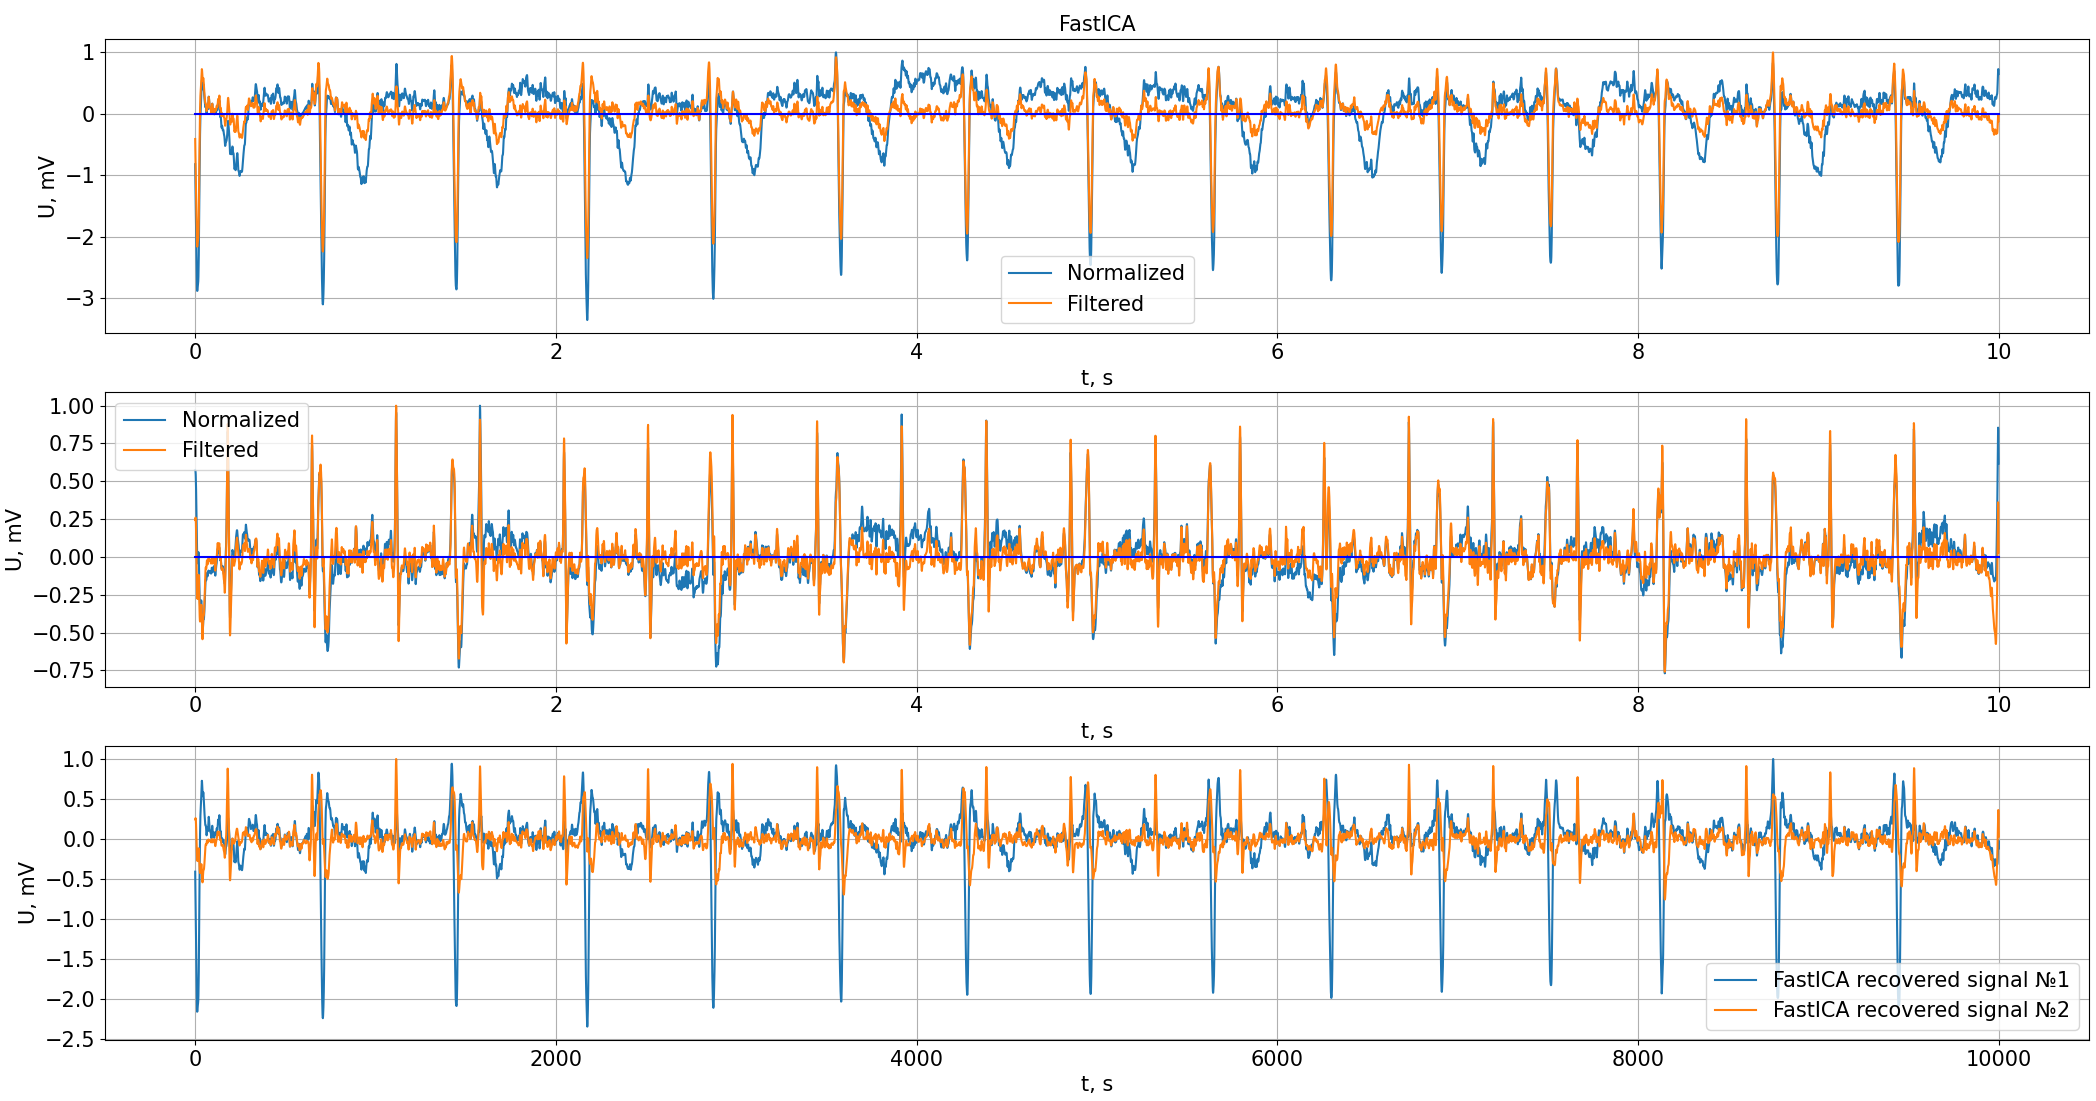

Output signals of the adaptive filter AP, data set “r01”

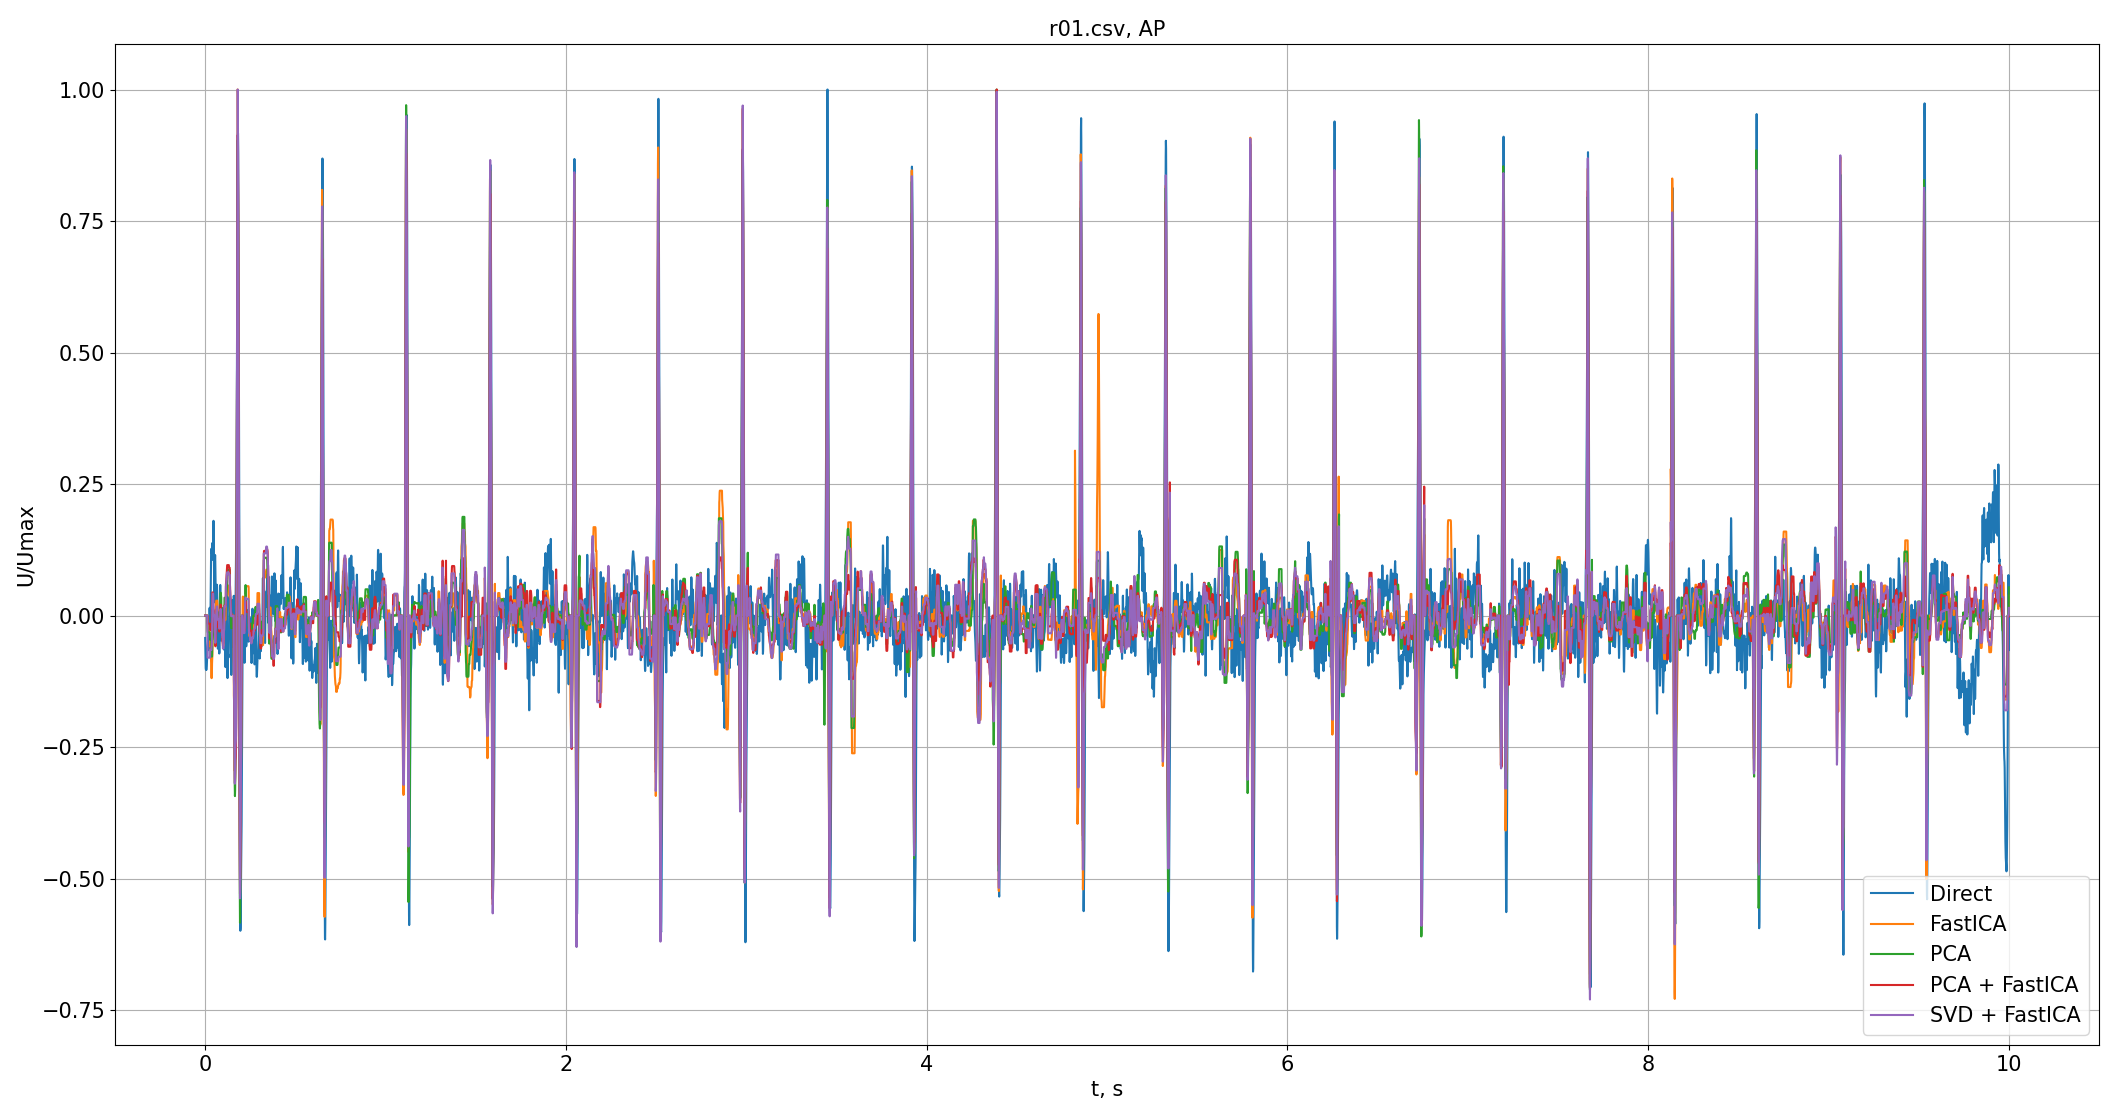

Scaled output signals of the adaptive filter GMCC (with smoothing filtering), data set “r01”

1.png

To show general results to each combination, let's plot dependence of the Pearson coefficient on the SNR based on eigenvalues coefficients for every patient.

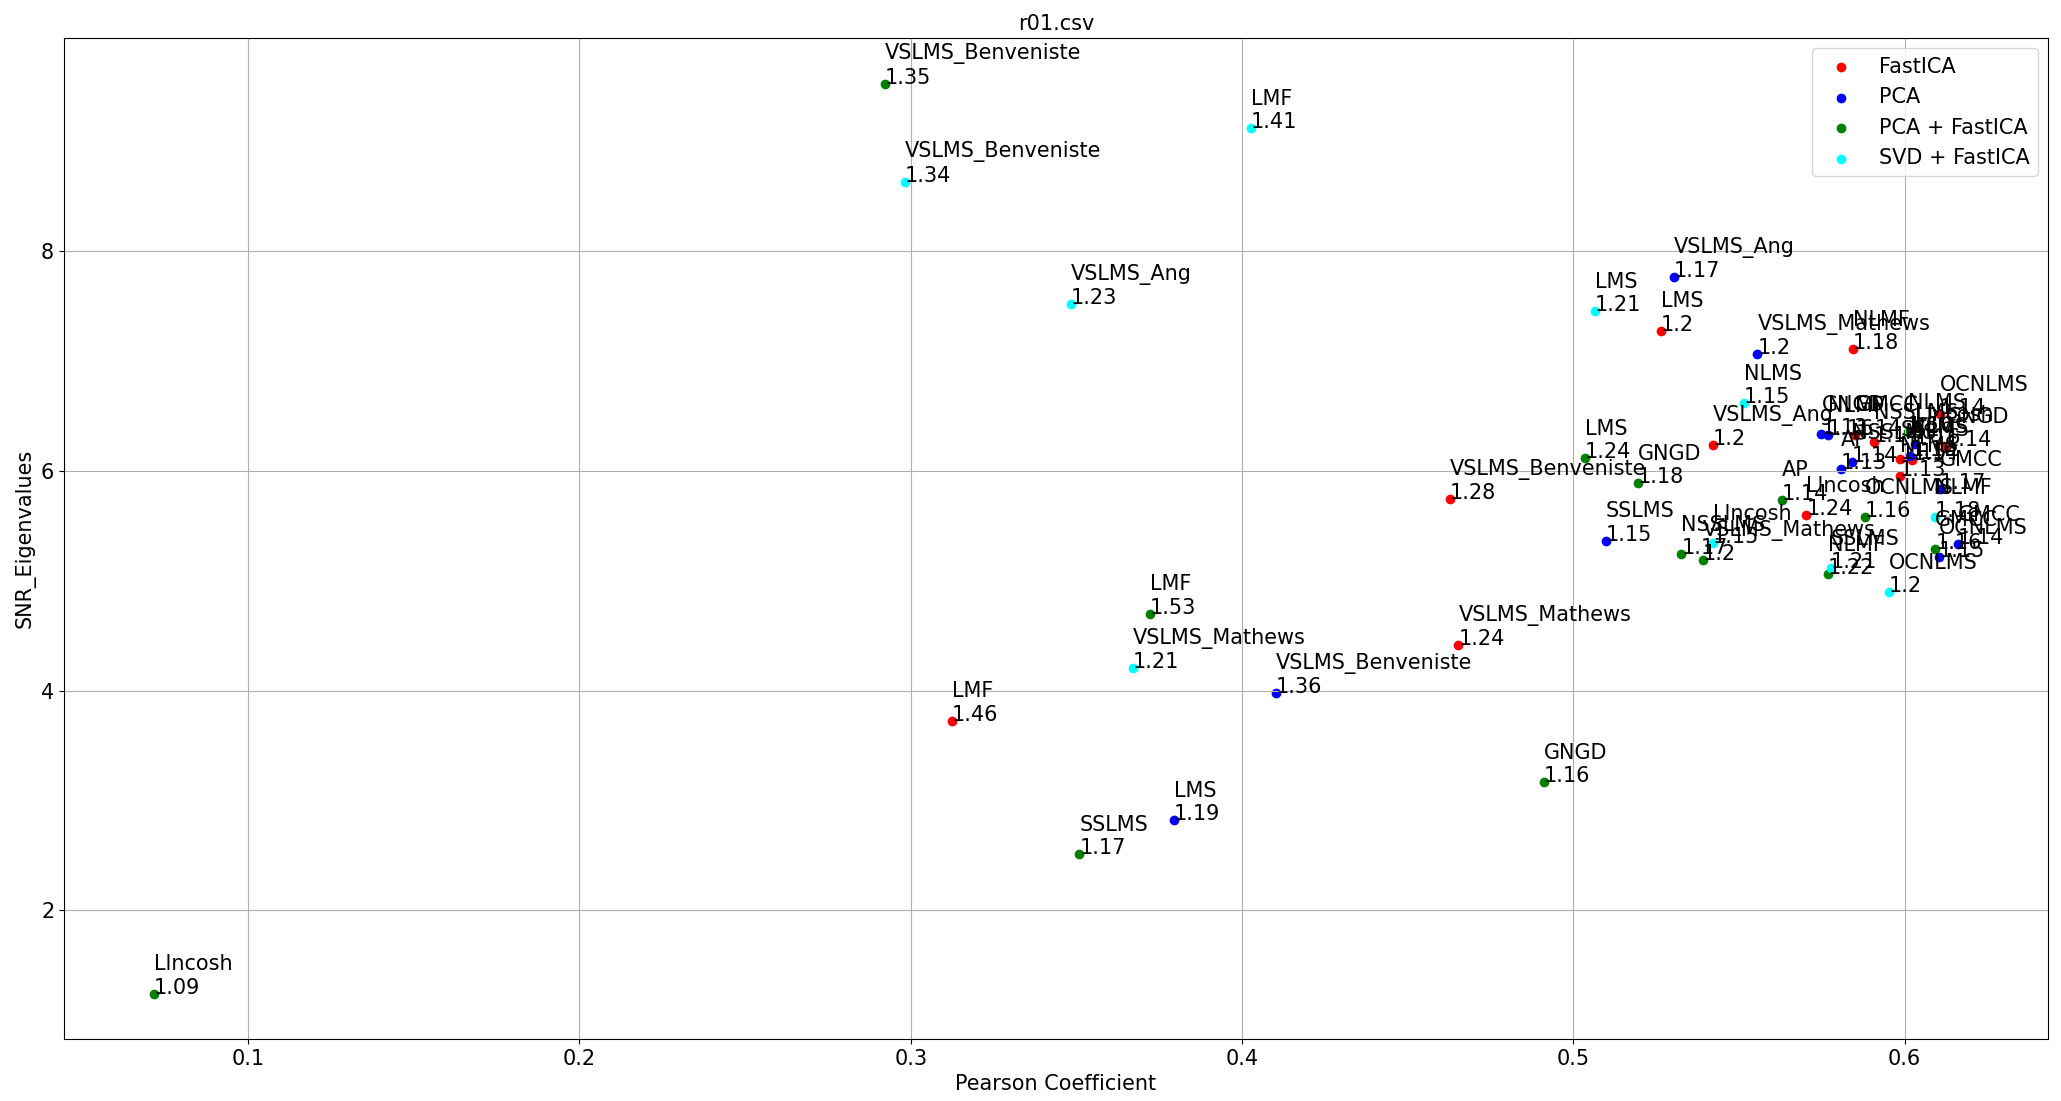
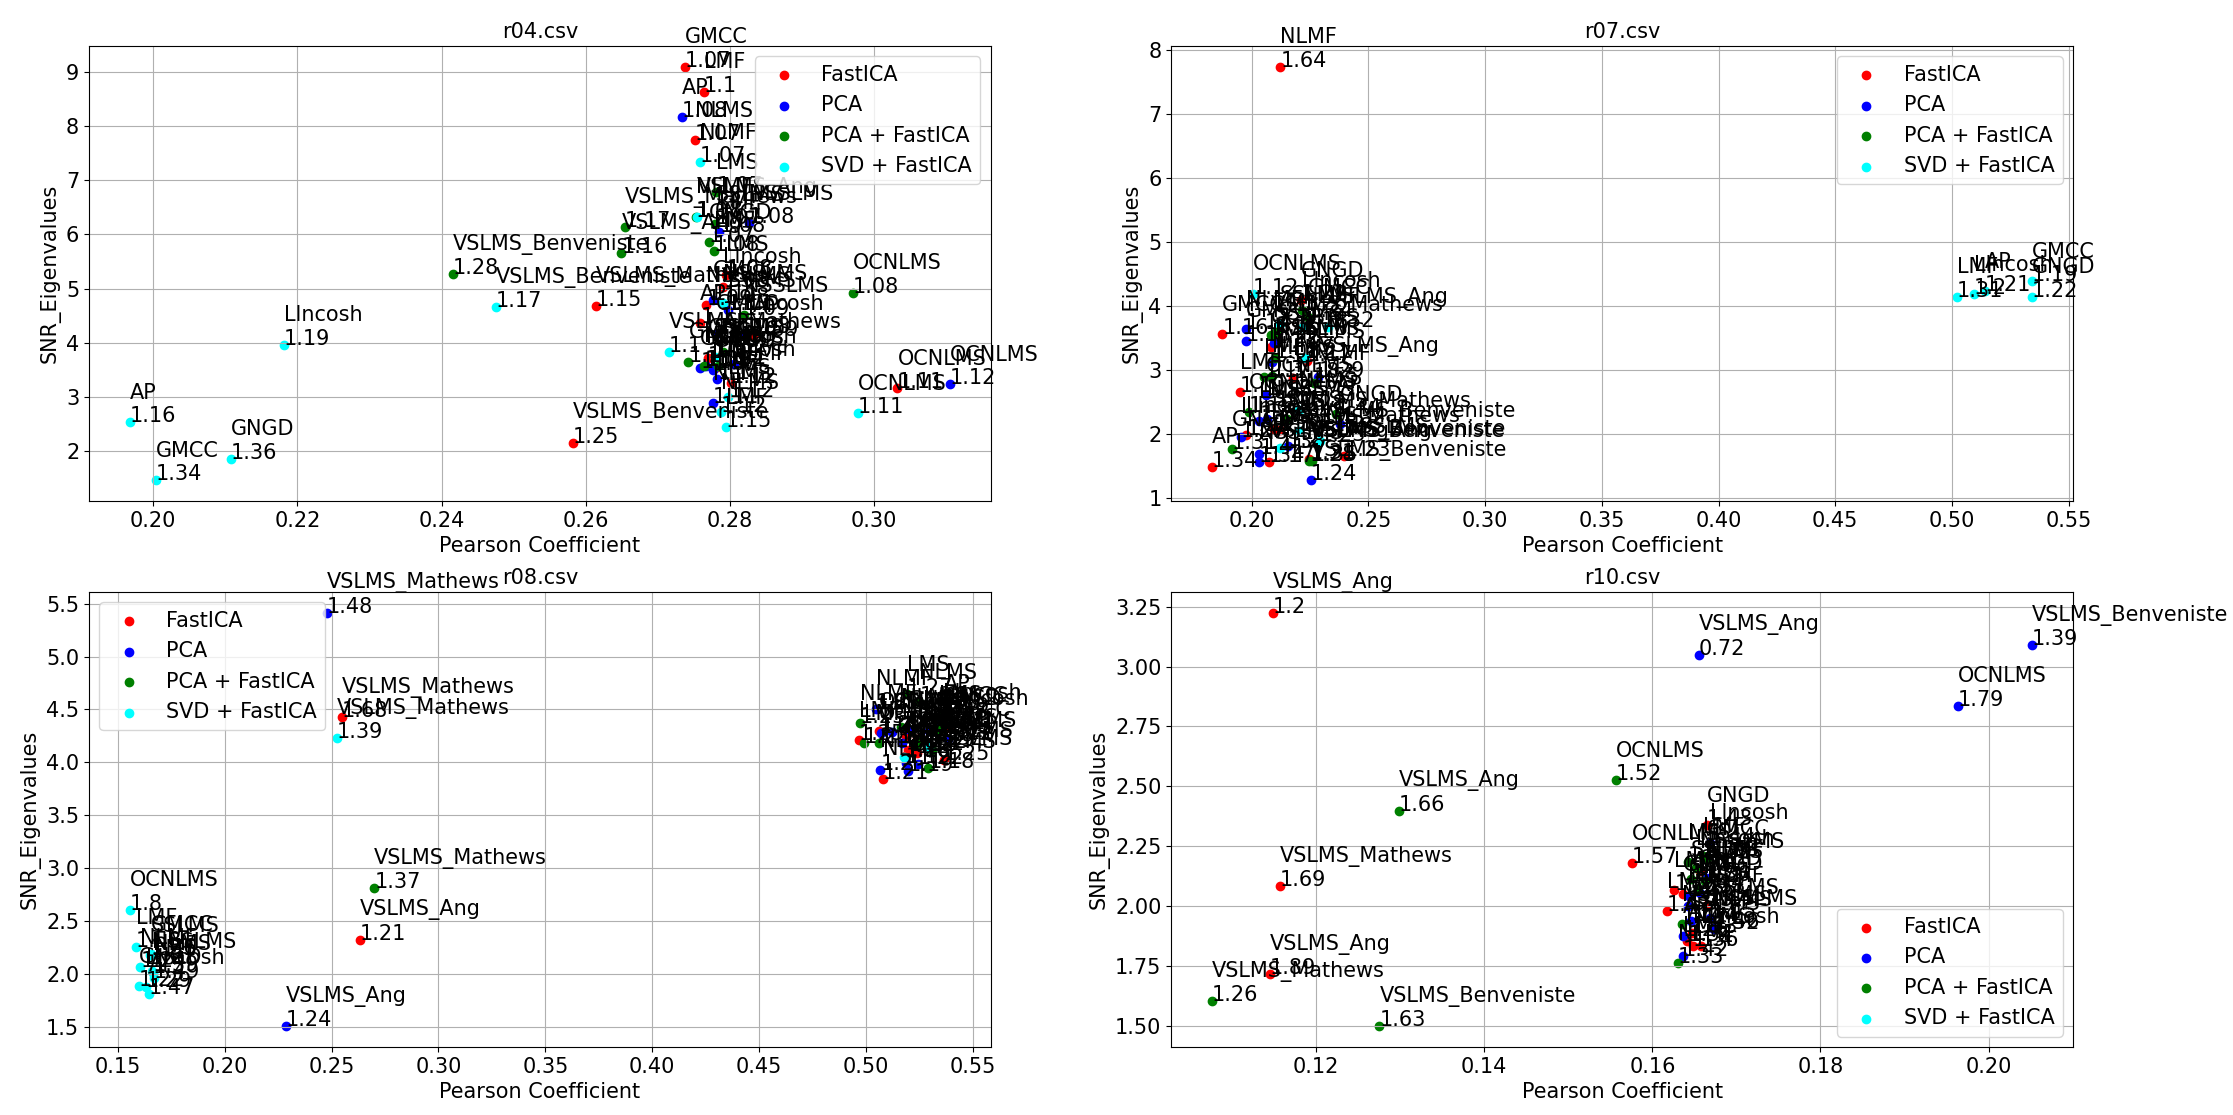

Analyzing the decompositions methods, we see that there is no combination that would be the best for all cases. We can highlight that combinations of signal processing with the FastICA algorithm have higher accuracy values, but in combination with the SVD algorithm - lower accuracy results (data sets “r04” and “r08”). The PCA algorithm performed worse than FastICA, but in combination - partially better results. Therefore, only FastICA and PCA + FastICA combinations will be analyzed in the following chapters.

Analyzing the adaptive filters, we see that LMF, AP and LMS (or their alternative versions) gave better accuracy results (compared to other filters). But it is still problematic to clearly select the best combination at this stage.

# Chapter 2. Fetal ECG Arrhythmia classification

More detailed algorithm of the first part presented in the following image.


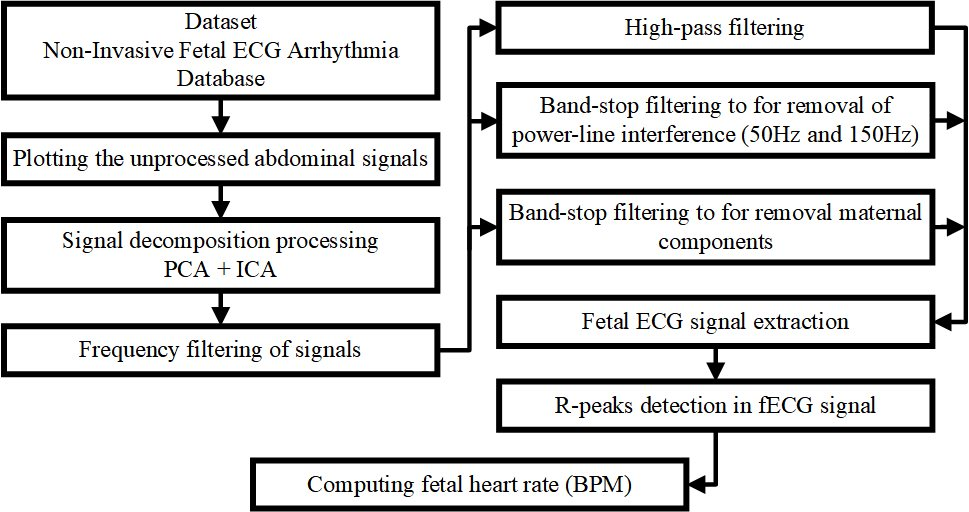

One of the disadvantages of using the signal processing method is the possible loss of important information adout fetus that can spoil the results. For example we can loss information about T-peak, which is one of a indicators of the different diseases. So, one of the possible solutions is computing heart rate of the fetus that can also determine the arrhythmia. There is a whole list of various diseases where the primary symptom is a specific heart rate signal. That is why we need a database with a similar disease, on the basis of which we will be able to classify ECG signals. Due to this explanation, the best database to solve this problem is "Non-invasive Fetal ECG Arrhythmia Database".

The database consists of two sets, namely healthy patients and patients with diagnosed arrhythmia. This will be used to form classes with or without arrhythmia.

The main focus is on the fetal heart rate, so additional signal processing operations will be performed. The first step is to set all signal samples that are less than zero to zero, since this information will not carry important information, but there will be less problems with normalization in the future. The second step is to analyze the signal in separate time windows (5 / 10 seconds) for improving data accuracy and to avoid problems with data normalization.

The learning rate to every adaptive filter based on previous chapter results (main_DataFrame_1). All current results will be summarized in dataFrame "main_DataFrame_2", which will include computed RR-intervals for each patient.

In [ ]:
!pip install wfdb

In [ ]:
##################### part 2 #####################

import wfdb

#################### step 2.1 ####################
# files path
file_path = "/content/drive/MyDrive/Colab Notebooks/non-invasive-fetal-ecg-arrhythmia-database-1.0.0/"
# creation a list of dat files
ecg_list = os.listdir(file_path)
mixed_dat_list = ' '.join(ecg_list)
dat_list = re.findall('\w+.dat', mixed_dat_list)
dat_list = [ecg[:-4] for ecg in dat_list]
# dataFrame with all signals and dictionary with signals general information
data_pd = pd.DataFrame()
fs = {'Signal': [],
      'Sample_freq': [],
      'Length_row': [],
      'Start_index': [],
      'Title': []}
# convert .dat to dataFrame
index = 0
for ii in range(len(dat_list)):
    # write new information to dataFrame
    record = wfdb.rdrecord(file_path + dat_list[ii])
    data_pd = pd.concat([data_pd, pd.DataFrame(record.p_signal)], axis = 1, ignore_index=True)
    fs['Length_row'].append(len(record.p_signal))
    fs['Start_index'].append(index)
    fs['Title'].append(record.sig_name)
    index += len(record.sig_name)
    # sample frequency
    fff = open(file_path + dat_list[ii]+'.hea','r')
    fs['Signal'].append(dat_list[ii])
    if "1000" in fff.read(): fs['Sample_freq'].append(1000)
    else: fs['Sample_freq'].append(500)
fs['Start_index'].append(index)
# new variables
abdom_pd = pd.DataFrame()
main_df_2 = {'Signal': [],
          'Adap filter': [],
          'RR interval': [],
          'Time R-peak': [],
          'processed signal': [],
          'Thorax signal': [],
          'Time': []}

#################### step 2.2 ####################
#  "for" loop to processing every signal
for ii in range(len(fs['Signal'])):
    # dataFrame for one patient
    abdom_pd = data_pd[0:fs['Length_row'][ii]].iloc[:, fs['Start_index'][ii]:fs['Start_index'][ii+1]]
    # time variable based on sample frequency (500Hz or 100Hz)
    time = 1/fs['Sample_freq'][ii]*np.linspace(0, fs['Length_row'][ii]-1, fs['Length_row'][ii])
    # computing number of signals (patient includes 5 or 6 abdominal signals)
    numb_of_sig = fs['Start_index'][ii+1]-fs['Start_index'][ii]
    # dataFrame with abdominal signals only
    abdominal_dataFrame = pd.DataFrame()
    for jj in range(len(fs['Title'][ii])):
        if fs['Title'][ii][jj] in re.findall('Abd+\w+\d', ' '.join(fs['Title'][ii])):
            abdominal_dataFrame = pd.concat([abdominal_dataFrame,
                                             pd.DataFrame({fs['Title'][ii][jj]: abdom_pd[fs['Start_index'][ii]+jj]})],
                                             axis = 1)
    # adaptive filters based on best accuracy coefficients on previous chapter
    for ee in range(14):
        if ee == 0:    adap_filt = pa.filters.FilterAP(n=numb_of_sig-1,order=4,mu=main_dataFrame_1['mu'][ee],ifc=1e-3,w="random")
        elif ee == 1:  adap_filt = pa.filters.FilterGMCC(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 2:  adap_filt = pa.filters.FilterGNGD(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 3:  adap_filt = pa.filters.FilterLlncosh(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],lambd=0.1,w="random")
        elif ee == 4:  adap_filt = pa.filters.FilterLMF(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 5:  adap_filt = pa.filters.FilterLMS(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 6:  adap_filt = pa.filters.FilterNLMF(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 7:  adap_filt = pa.filters.FilterNLMS(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 8:  adap_filt = pa.filters.FilterNSSLMS(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 9:  adap_filt = pa.filters.FilterOCNLMS(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random",mem=100)
        elif ee == 10: adap_filt = pa.filters.FilterSSLMS(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],w="random")
        elif ee == 11: adap_filt = pa.filters.FilterVSLMS_Ang(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],ro=1e-15,w="random")
        elif ee == 12: adap_filt = pa.filters.FilterVSLMS_Benveniste(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],ro=1e-15,w="random")
        elif ee == 13: adap_filt = pa.filters.FilterVSLMS_Mathews(n=numb_of_sig-1,mu=main_dataFrame_1['mu'][ee],ro=1e-15,w="random")
        # the best accuracy coefficients have PCA + ICA combination
        # PCA decomposition
        pca = SparsePCA(n_components=2, random_state=42)
        PCA_data = pca.fit_transform(abdominal_dataFrame)
        # Compute ICA
        ica = FastICA(n_components=2, whiten="arbitrary-variance", random_state=42)
        rec_sig = ica.fit_transform(PCA_data)  # Reconstruct signals
        title_n = "PCA + FastICA"
        # filtering settings
        b_0, a_0 = scipy.signal.butter(1, 1e-2, 'highpass')
        # empty filtered reconstracted signal
        filt_rec_sig = np.zeros([len(rec_sig), 2])
        # filtering of reconstructed signals
        filt_rec_sig[:, 0] = scipy.signal.filtfilt(b_0, a_0, rec_sig[:, 0])
        filt_rec_sig[:, 1] = scipy.signal.filtfilt(b_0, a_0, rec_sig[:, 1])
        # normalizing
        filt_rec_sig[:, 0] = filt_rec_sig[:, 0] / max(filt_rec_sig[:, 0])
        filt_rec_sig[:, 1] = filt_rec_sig[:, 1] / max(filt_rec_sig[:, 1])
        # adaptive filtering
        _, e, _ = adap_filt.run(filt_rec_sig[:, 0], abdominal_dataFrame.values)
        # highpass filtering
        b, a = scipy.signal.butter(1, 8e-2, 'highpass')
        f_HP = scipy.signal.filtfilt(b, a, e)
        # normalizing
        ECG_sig = f_HP/max(f_HP)
        # bandstop filters settings
        b_1, a_1 = signal.iirnotch(50, 30, fs['Sample_freq'][ii])
        b_2, a_2 = signal.iirnotch(150, 30, fs['Sample_freq'][ii])
        sos = scipy.signal.butter(10, 21, 'highpass', fs=fs['Sample_freq'][ii], output='sos')

        #################### step 2.3 ####################
        # size of time-window to compute RR-interval
        time_param = 5
        # computing time-window samples
        numb_count = time_param*fs['Sample_freq'][ii]*np.linspace(0,int(np.floor(time[-1]/time_param)),int(np.floor(time[-1]/time_param))+1)
        numb_count = (np.append(numb_count, fs['Length_row'][ii])).astype(int)
        # empty variables
        t_R_peak_array = []
        full_signal = []
        # computing location of R-peaks
        for aa in range(len(numb_count)-1):
            # 5-second window variable
            cut_signal = ECG_sig[numb_count[aa]:numb_count[aa+1]]
            cut_time = time[numb_count[aa]:numb_count[aa+1]]
            if aa == 0:
                cut_signal[0:int(0.1*fs['Sample_freq'][ii])] = np.zeros([len(cut_signal[0:int(0.1*fs['Sample_freq'][ii])])])
            # requirement to band-stop filtering
            if len(cut_signal) > 33:
                # filtering and normalizing
                filt_sig = scipy.signal.sosfiltfilt(sos, cut_signal)
                filt_sig = scipy.signal.filtfilt(b_1, a_1, filt_sig)
                filt_sig = scipy.signal.filtfilt(b_2, a_2, filt_sig)
                filt_sig[filt_sig<0] = np.zeros([len(filt_sig[filt_sig<0])])
                if sum(filt_sig) == 0:
                    filt_sig = filt_sig
                else:
                    filt_sig = filt_sig/max(filt_sig)
                full_signal.append(filt_sig)
                for jj in range(1, len(filt_sig)-1):
                    if filt_sig[jj]>filt_sig[jj+1] and filt_sig[jj]>filt_sig[jj-1] and filt_sig[jj]>0.50:
                        t_R_peak_array.append(cut_time[jj])
        # convertation to single signal
        processed_new_sig = [x for l in full_signal for x in l]
        # "for" loop for RR-interval
        RR_inter = []
        BPM_arr = []
        for jj in range(len(t_R_peak_array)-1):
            RR_inter.append(t_R_peak_array[jj+1] - t_R_peak_array[jj])
            BPM_arr.append(60/RR_inter[jj])
        # save data
        main_df_2['Signal'].append(fs['Signal'][ii])
        main_df_2['Adap filter'].append(adap_filt.kind)
        main_df_2['RR interval'].append(RR_inter)
        main_df_2['Time R-peak'].append(t_R_peak_array[0:-1])
        main_df_2['processed signal'].append(processed_new_sig)
        main_df_2['Thorax signal'].append(abdom_pd[fs['Start_index'][ii]]/max(abdom_pd[fs['Start_index'][ii]]))
        main_df_2['Time'].append(time)
main_dataFrame_2 = pd.DataFrame(main_df_2)

In [ ]:
main_dataFrame_2 = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/DF_files/main_dataFrame_2_5_2.gzip")

In [ ]:
main_dataFrame_2.head()

Signal Adap filter                                        RR interval  \
0  ARR_01          AP  [0.47500000000000003, 0.45799999999999996, 0.2...   
1  ARR_01        GMCC  [0.47600000000000003, 0.45699999999999996, 0.2...   
2  ARR_01        GNGD  [0.47500000000000003, 0.45799999999999996, 0.2...   
3  ARR_01     Llncosh  [0.47700000000000004, 0.45699999999999996, 0.2...   
4  ARR_01         LMF  [0.47500000000000003, 0.45799999999999996, 0.2...   

                                         Time R-peak  \
0  [0.291, 0.766, 1.224, 1.5150000000000001, 2.08...   
1  [0.291, 0.767, 1.224, 1.5150000000000001, 2.08...   
2  [0.291, 0.766, 1.224, 1.5150000000000001, 2.08...   
3  [0.29, 0.767, 1.224, 1.5150000000000001, 2.08,...   
4  [0.291, 0.766, 1.224, 1.5150000000000001, 2.08...   

                                                Time  
0  [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006...  
1  [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006...  
2  [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006...  
3  [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006...  
4  [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006...

Abdominal signals for fetus with arrhythmia and Thorax signals for mother a, set "ARR_01"

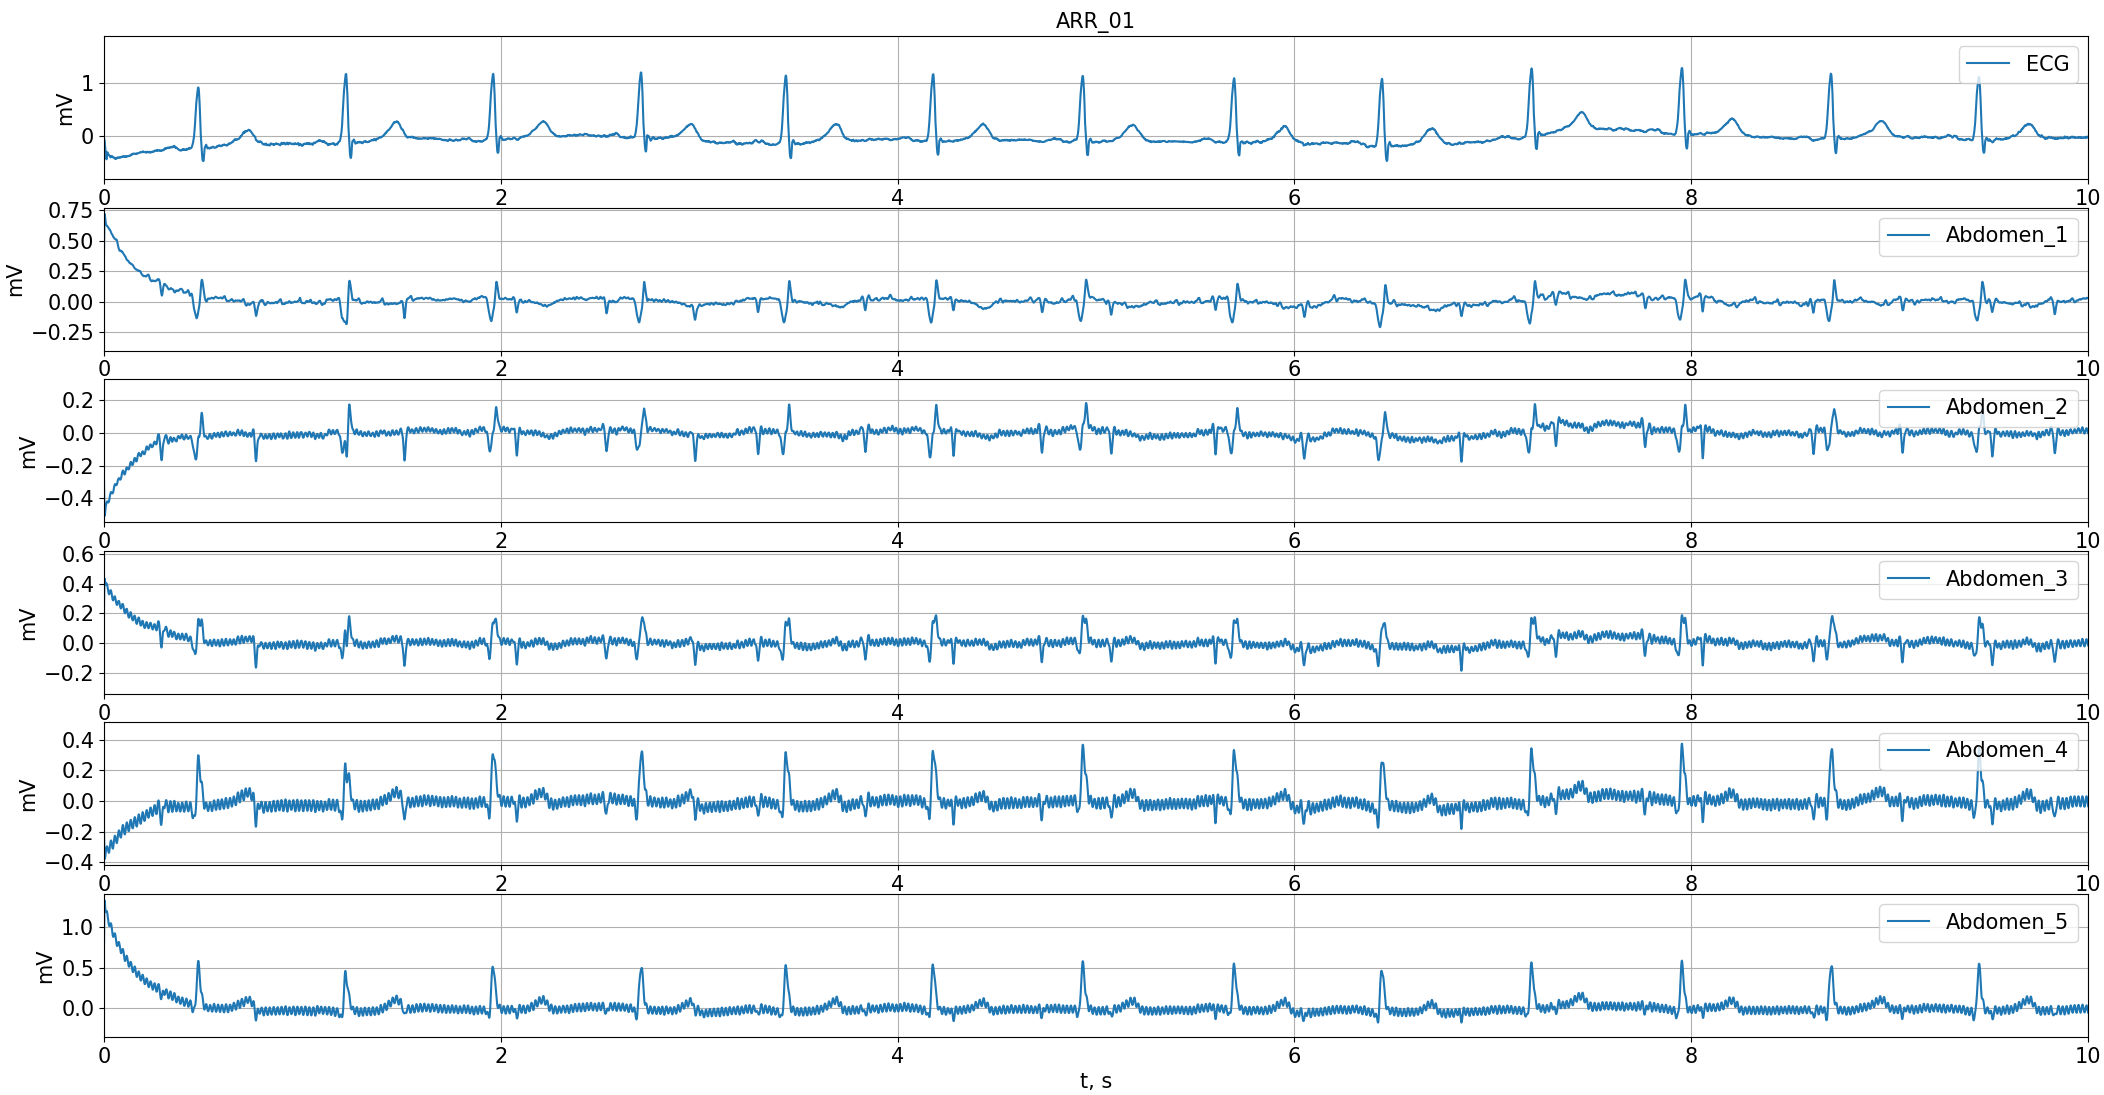

Fetal ECG signal and amplitude-frequency characteristic (without powerline 50Hz filtering), set “ARR_01”

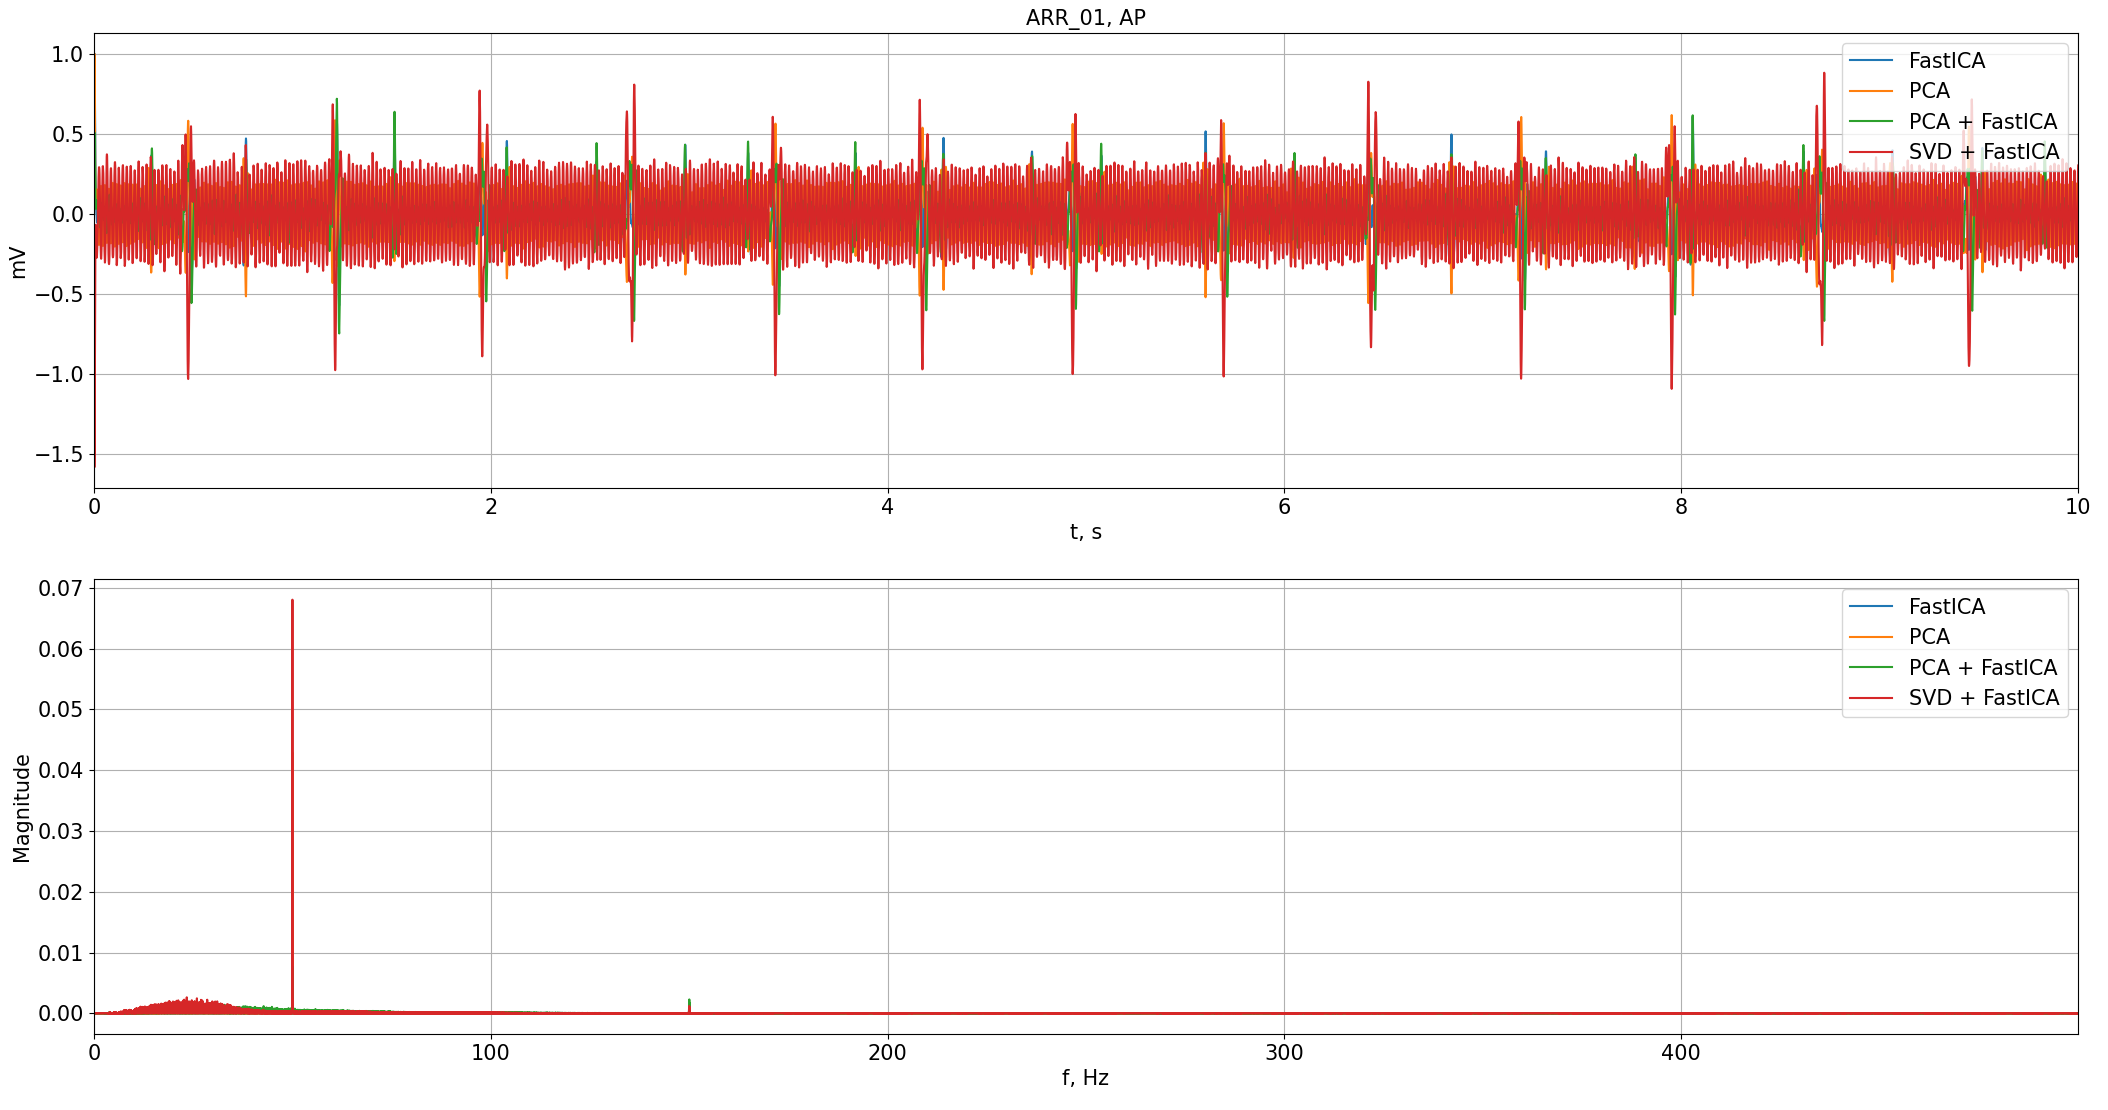

Fetal ECG signal and amplitude-frequency characteristic (with powerline 50Hz filtering), set “ARR_01”

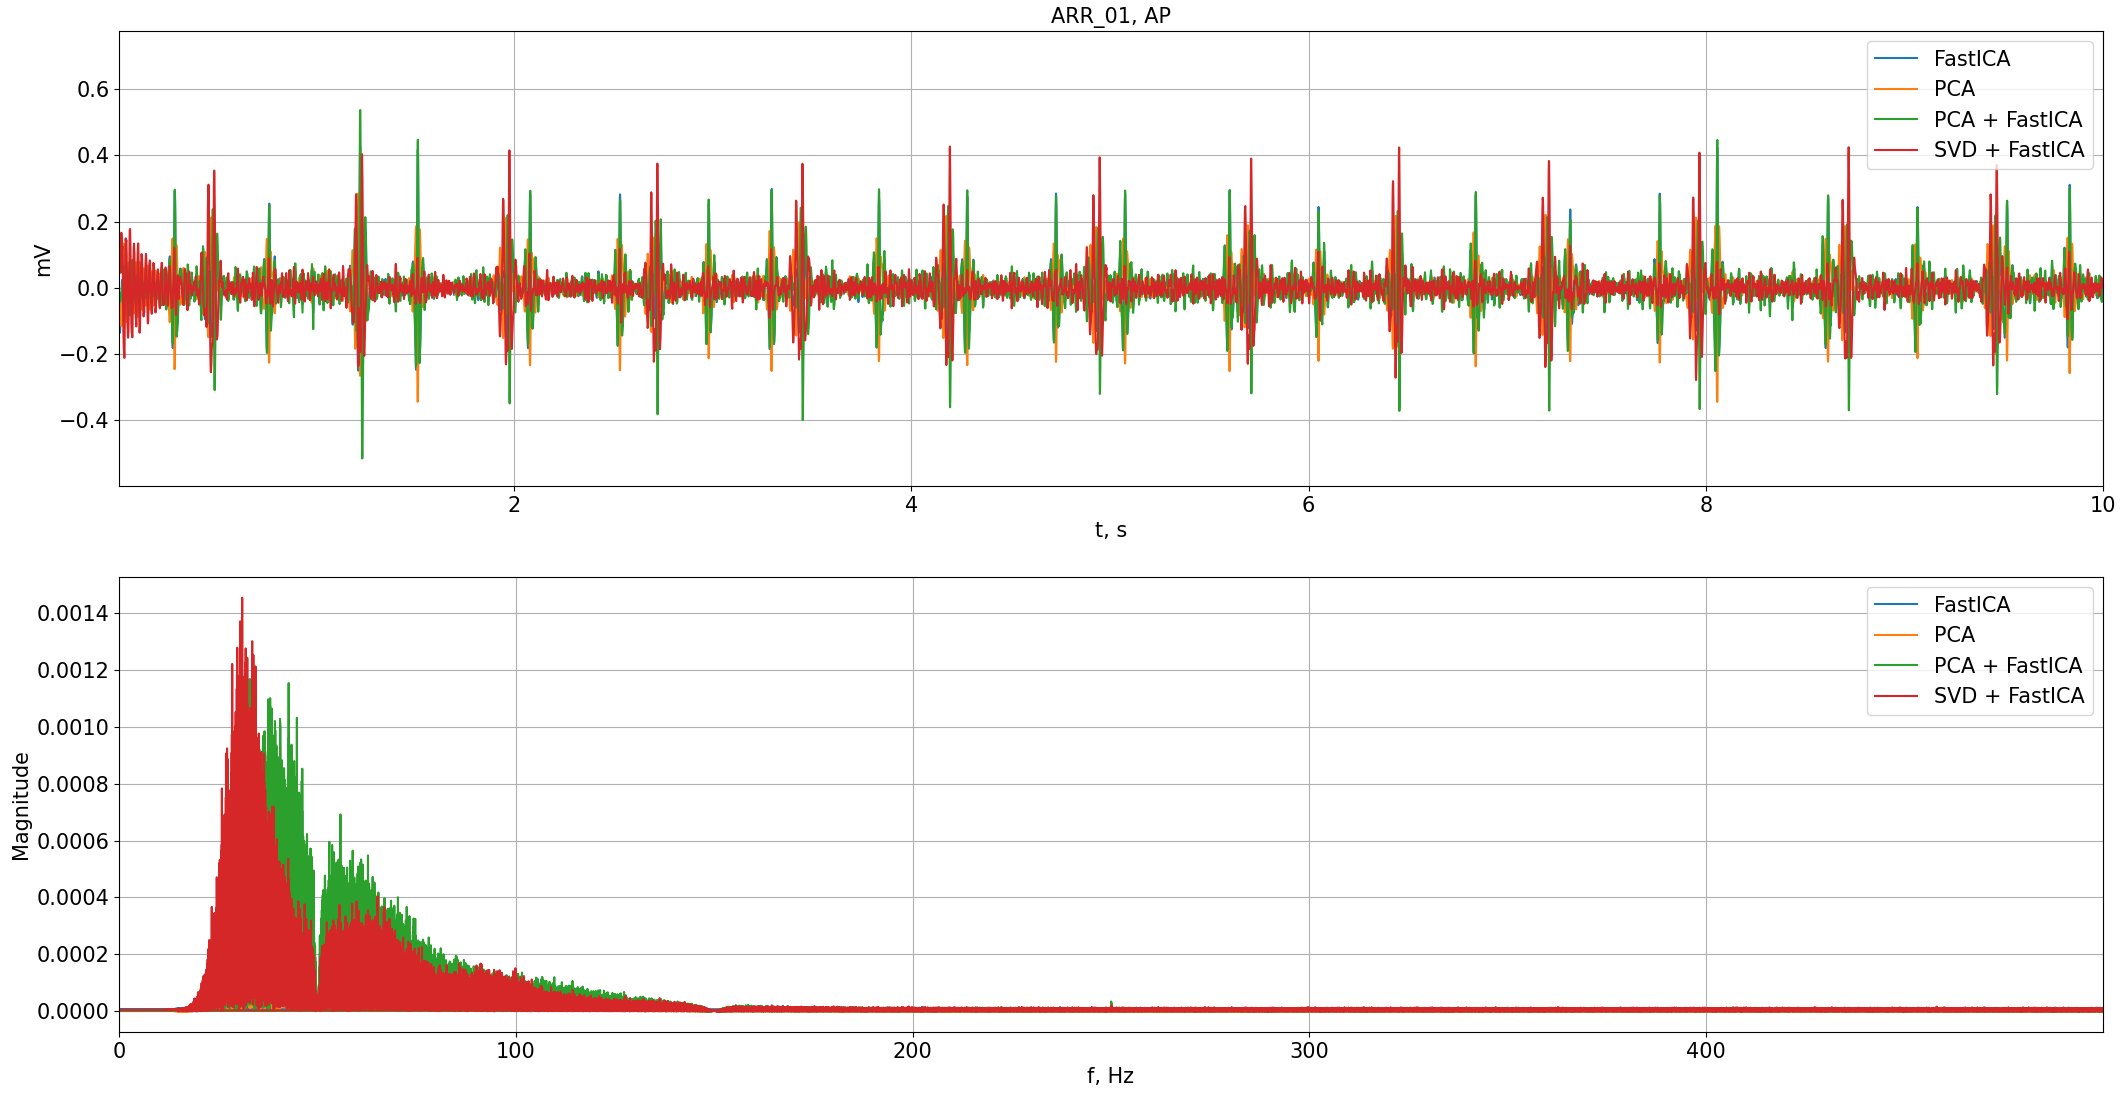

Fetal ECG signal and amplitude-frequency characteristic (with removal maternal component), set “ARR_01”

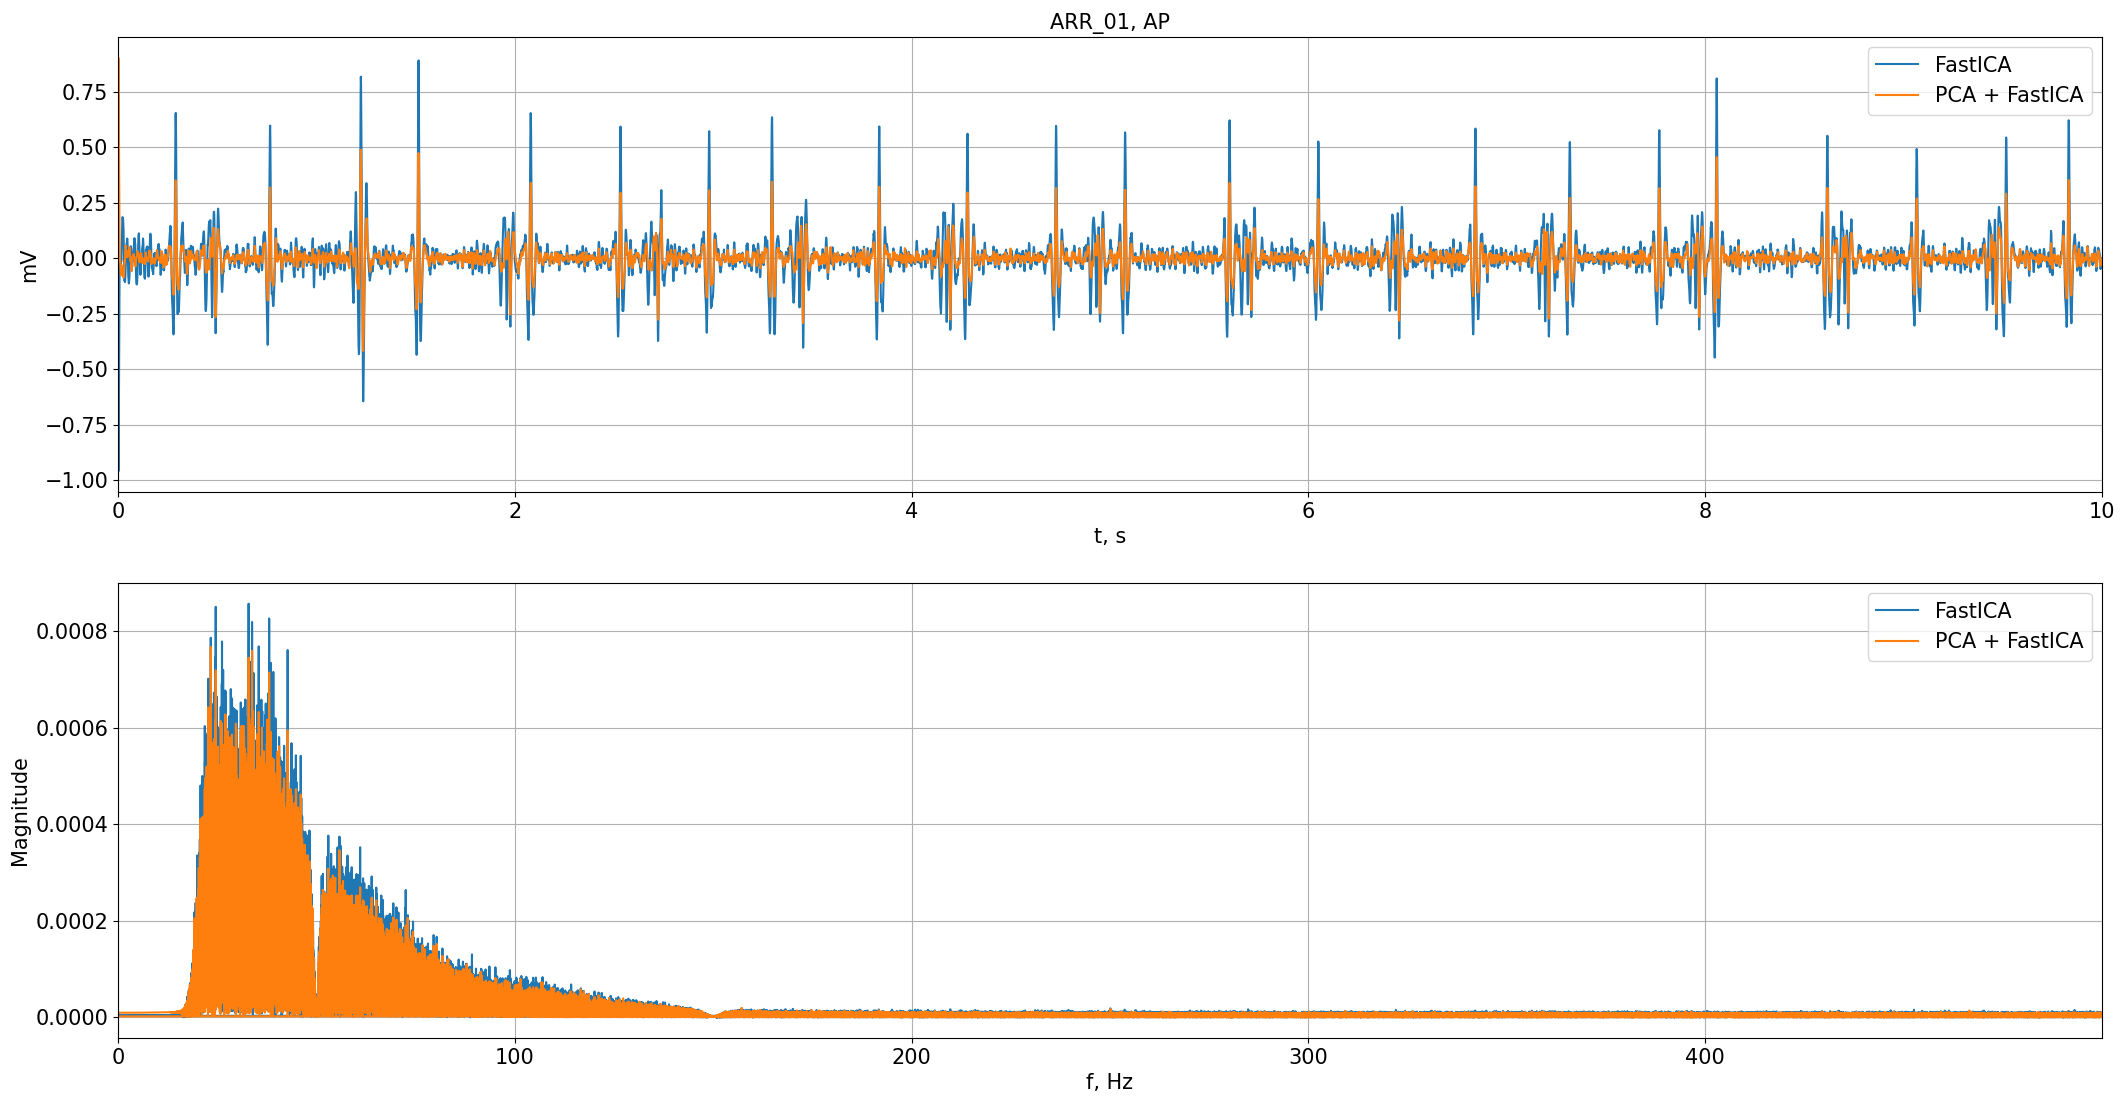

Processed fetal ECG signal for heart rate calculation with maternal thoracic signal

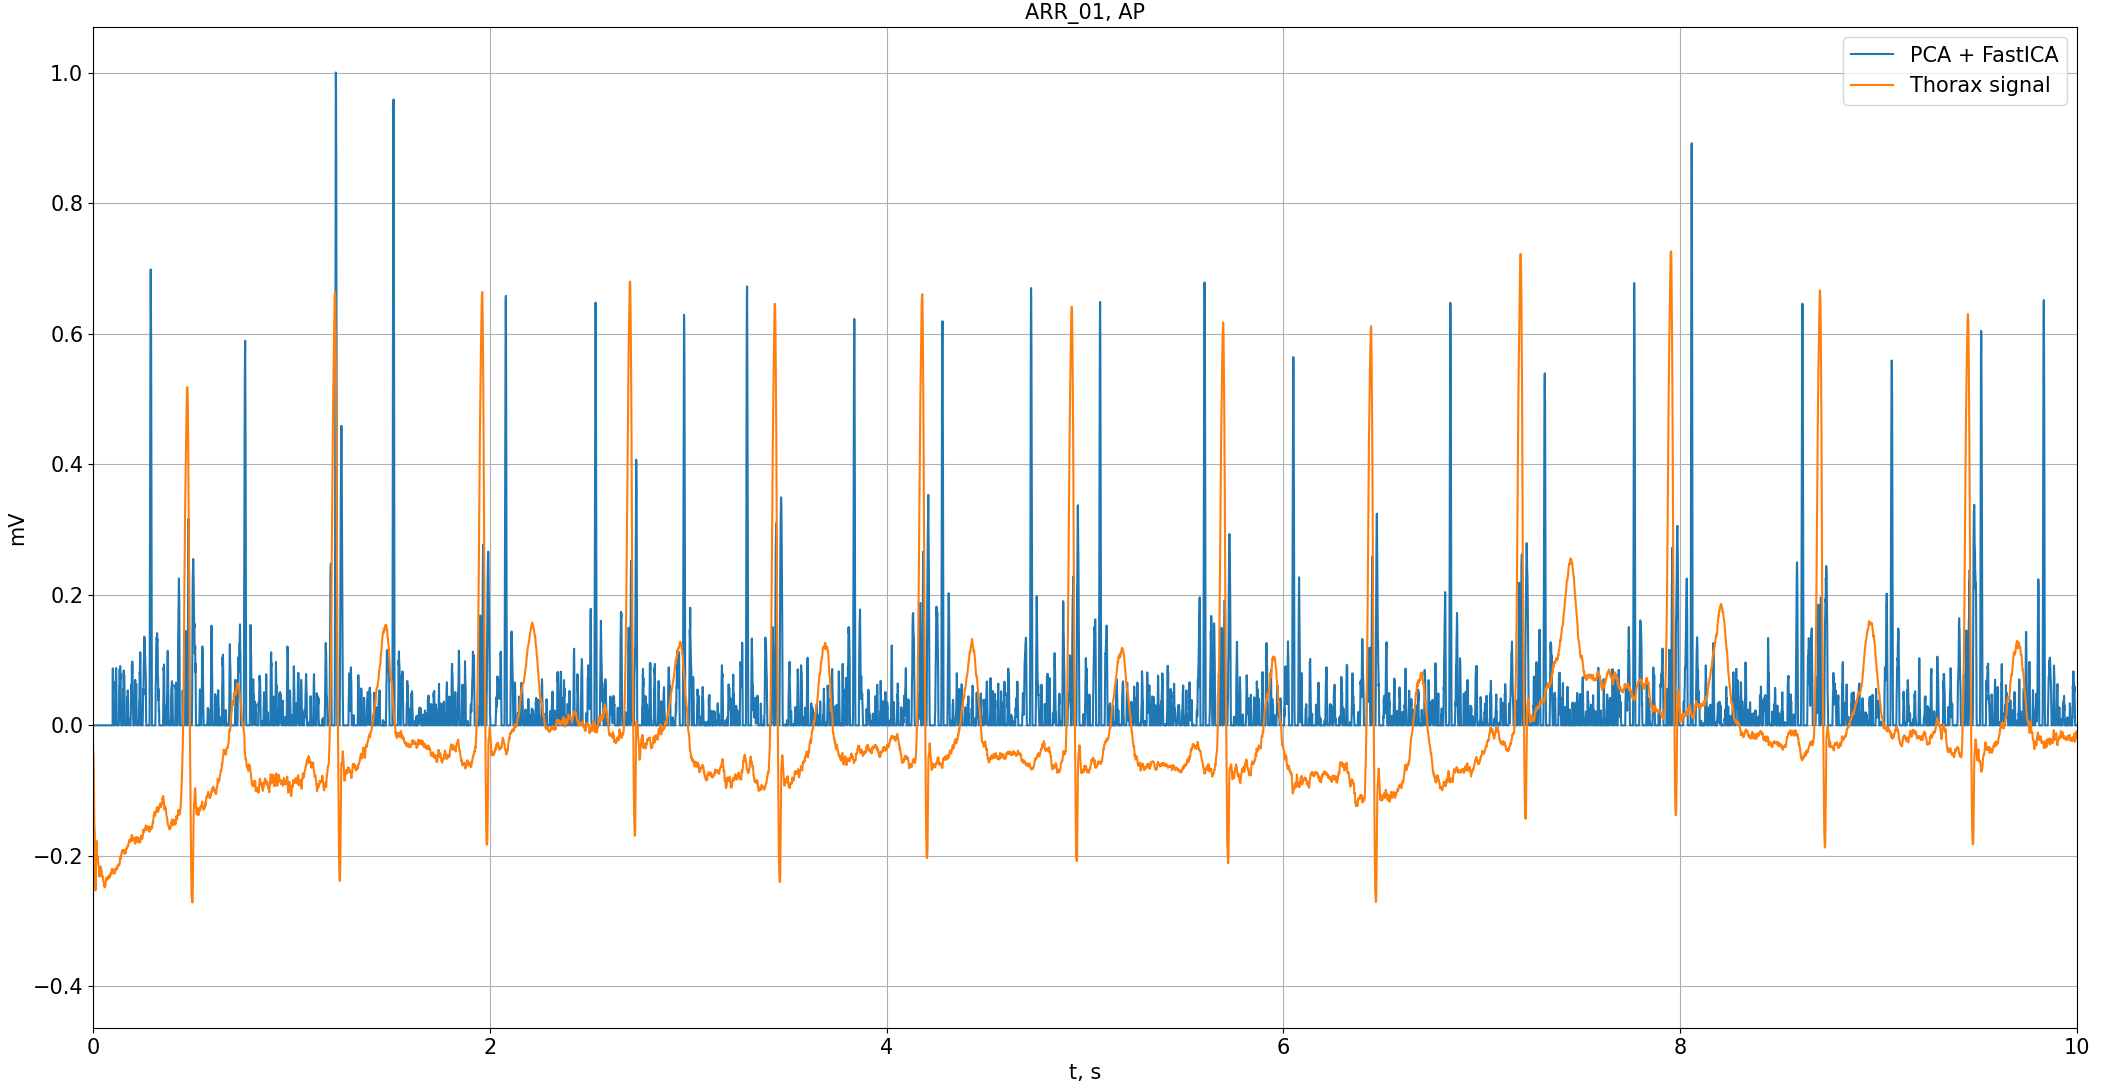

Dependence of RR-intervals on time and processed ECG signal for a patient with arrhythmia (PAC)

Black lines - detected fetal R-peaks

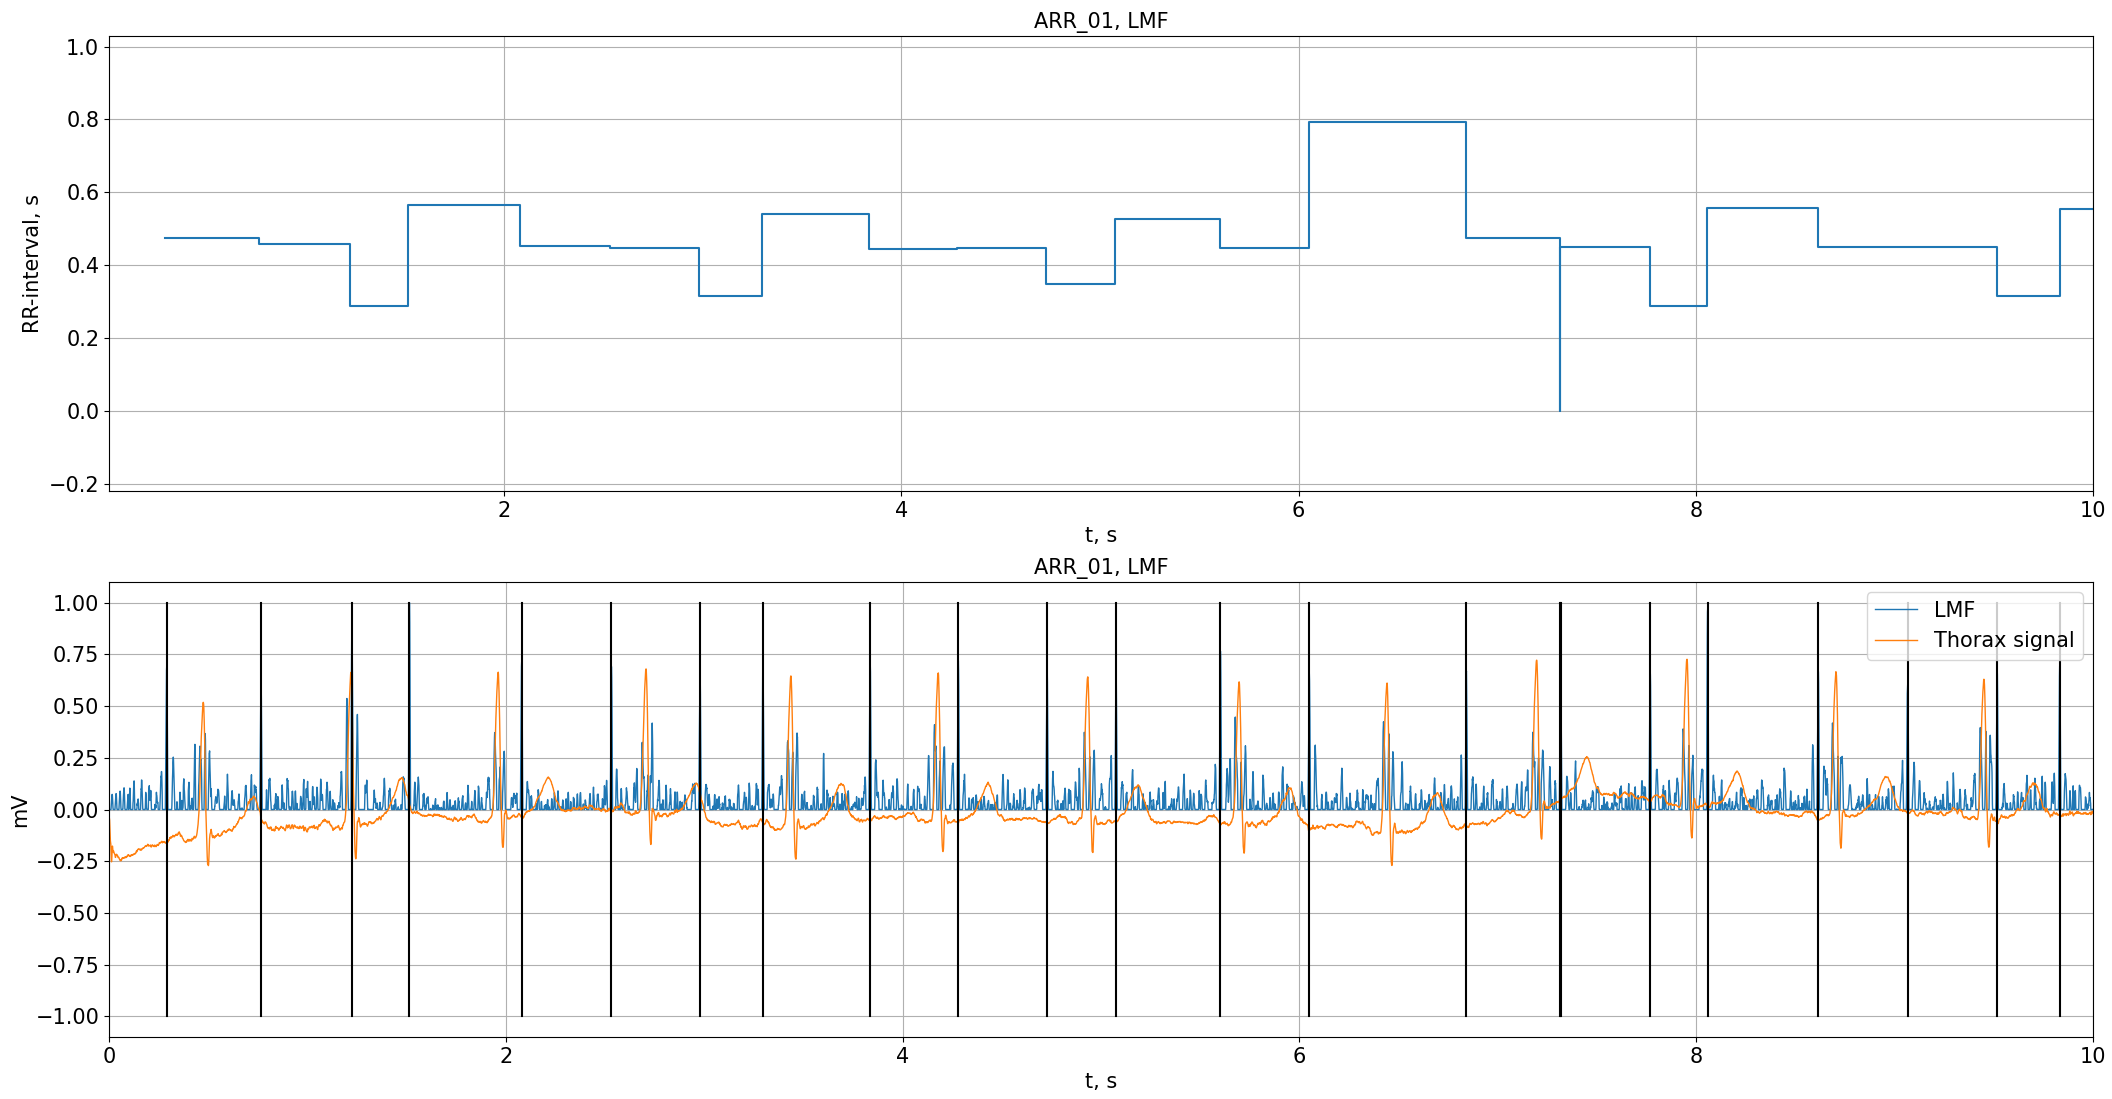

Dependence of RR-intervals on time and processed ECG signal for a patient with arrhythmia (tachycardia)

1.png

Dependence of RR-intervals on time and processed ECG signal for a patient without arrhythmia

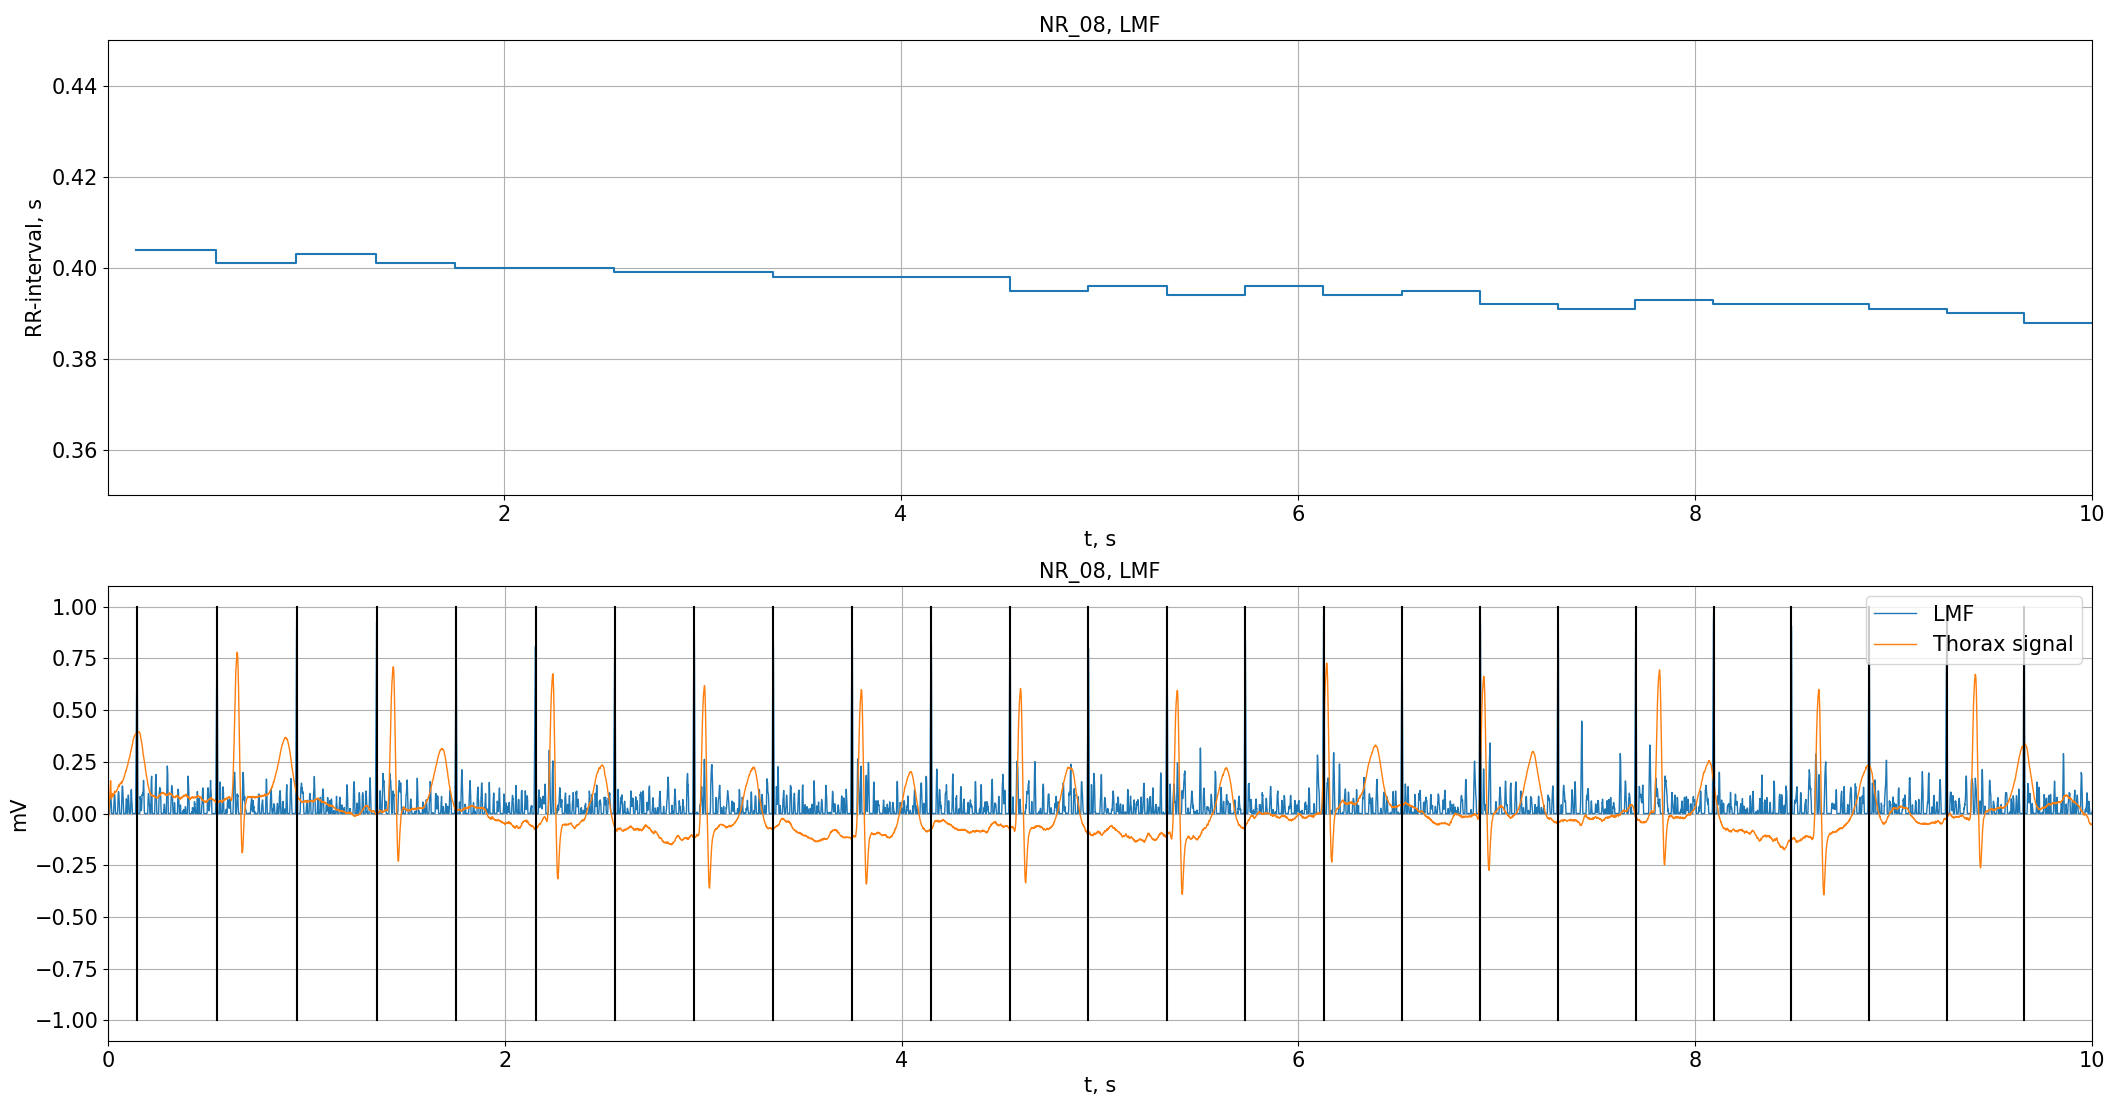

Dependence of fetal heart rate (BPM) on time for a patient with arrhythmia (PAC)

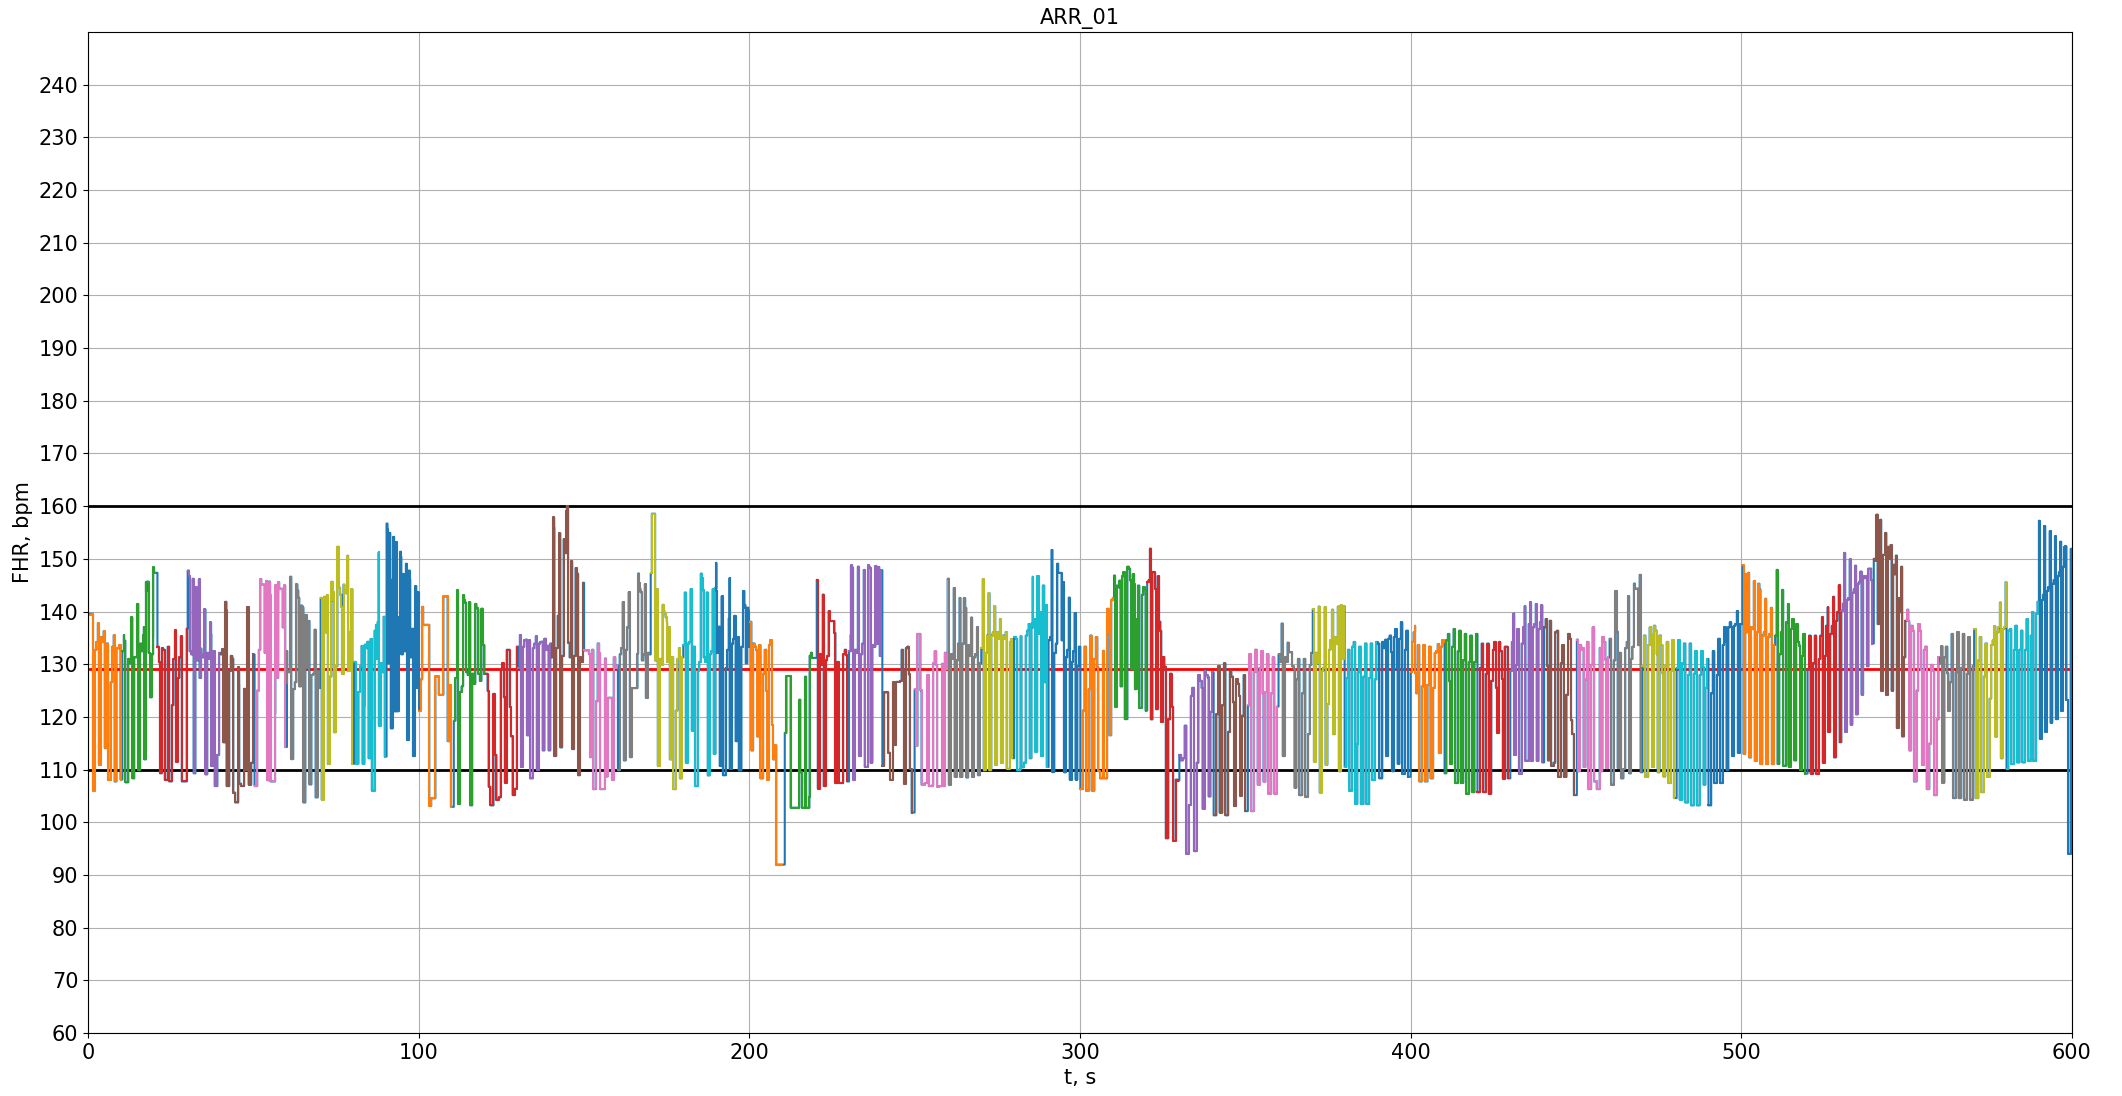

Dependence of fetal heart rate (BPM) on time for a patient with complex arrhythmia (PAC, tachycardia, 2:1 AV)

1.png

Dependence of fetal heart rate (BPM) on time for a patient without arrhythmia

1.png

After these operations for all examples \ signals, the next step is to extract features and train the prediction arhythmia model using machine learning methods.

# Chapter 3. Prediction model using machine learning methods

The final part of this research is to extract features of ECG signals with arhythmia \ healthy patients and to create a model to predict fetal arrhythmia. One of the possible way to solve ECG signals classification task is to use autoregressive model by Burg algorithm.

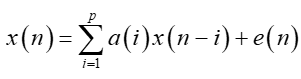

The main problem is to compute the order of the AR model, because, on the one hand, higher order leads to higher accuracy (in most cases), but, on the other hand, processing time will also be longer.
That's why, for start, we have to plot the dependence of the classifiers accuracy (and classifier cross-validation coefficient) on the AR order.

In [ ]:
##################### part 3 #####################

import re
import pandas as pd
import numpy as np
from scipy import signal
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

#################### step 3.1 ####################

df_cr_val = {'Model':[],
             'Order':[],
             'mean_test_score':[],
             'accuracy':[],
             'cf_matrix': []}
for order in range(3, 36, 4):  # order of AR model
    rho_var = {'Patient': [], 'Coeffs': []}
    for ii in range(0, main_dataFrame_2.shape[0]):
        # computing fHR, BPM
        BPM_arr = []
        for jj in range(len(main_dataFrame_2['Time R-peak'][ii])):
            BPM_arr.append(60/main_dataFrame_2['RR interval'][ii][jj])
        # top and bot value of BPM for fetus
        top = 250
        bot = 60
        # algorithm for BPM normalization
        for jj in range(0, len(BPM_arr)):
            if BPM_arr[jj] > top or BPM_arr[jj] < bot:
                index_BPM = (np.logical_and(np.array(BPM_arr[jj:])<top, (np.array(BPM_arr[jj:])>bot)).tolist())
                # fHR can vary in range from 5 to 25 BPM
                if sum(index_BPM) == 0:
                    BPM_arr[jj] = BPM_arr[jj-1] + (np.random.randint(5, size=(1, 1))).flatten()
                else:
                    norm_BPM = BPM_arr[index_BPM.index(1)]
                    if jj == 0:
                        BPM_arr[jj] = norm_BPM + (np.random.randint(5, size=(1, 1))).flatten()
                    elif jj == len(BPM_arr)-1:
                        BPM_arr[jj] = BPM_arr[jj-1] + (np.random.randint(5, size=(1, 1))).flatten()
                    else:
                        BPM_arr[jj] = (BPM_arr[jj-1] + norm_BPM)/2
        # new values
        count = [] # samples of fHR signal
        fecg_filtered = signal.medfilt(BPM_arr, kernel_size=29) # smoothing filtering
        index_1, index_2 = 0, 0 # indexes based on samples
        for jj in range(int(main_dataFrame_2['Time R-peak'][ii][-1]//time_param)):
            count = np.logical_and(np.array(main_dataFrame_2['Time R-peak'][ii])>=int(time_param*jj),
                                   np.array(main_dataFrame_2['Time R-peak'][ii])<=int(time_param*(jj+1))).astype(int)
            # indexes
            if sum(count.tolist()) == 0: break
            else: index_1 = (count.tolist()).index(1)
            index_2 = index_1 + sum(count.tolist())
            # cut all signals according to samples
            t_R_peak_cut = main_dataFrame_2['Time R-peak'][ii][index_1:index_2]
            BPM_cut = BPM_arr[index_1:index_2]
            fBMP = fecg_filtered[index_1:index_2]
            # convert signal to another signal with higher sample frequency
            index_1_n = 5
            new_BPM = []
            for bb in range(len(BPM_cut)-1):
                index_2_n = (BPM_cut[bb+1] - BPM_cut[bb])/index_1_n
                for aa in range(int(index_1_n)):
                    new_BPM.append(BPM_cut[bb]+index_2_n)
            new_BPM.append(BPM_cut[-1])
            # AR model rule abour len(signal) > AR model order
            if len(new_BPM) > order:
                rho, _ = sm.regression.linear_model.burg(new_BPM, order=order)
                if sum(np.isnan(rho)) == 0:
                    rho_var['Patient'].append(main_dataFrame_2['Signal'][ii])
                    rho_var['Coeffs'].append(rho)

    #################### step 3.2 ####################

    rho_pd = pd.DataFrame(rho_var)
    mixed_list = ''.join(rho_pd['Patient'].values)
    rho_pd['Patient'] = re.findall('\D+', mixed_list)
    rho_pd['Patient'] = (rho_pd['Patient'] == 'NR_')*0 + (rho_pd['Patient'] == 'ARR_')*1
    # list of classifiers
    Classifiers = {'KNN':   KNeighborsClassifier(),
                   'TREE':  DecisionTreeClassifier(),
                   'RF':    RandomForestClassifier(),
                   'LR':    LogisticRegression(),
                   'AB':    AdaBoostClassifier(),
                   'ETC':   ExtraTreesClassifier(),
                   'LDA':   LinearDiscriminantAnalysis(),
                   'SVC':   SVC(),
                   'GBC':   GradientBoostingClassifier(),
                   'GNB':   GaussianNB(),
                   'BNB':   BernoulliNB(),
                   'LSVC':  LinearSVC(),
                   'MLP':   MLPClassifier()}
    # accuracy dataFrame
    df_cr_val['Model'].append(list(Classifiers.keys()))
    df_cr_val['Order'].append(order + np.zeros([len(list(Classifiers.keys()))]))
    # compute accuracy of each classifier
    rho_pd = rho_pd.join(pd.DataFrame(rho_pd['Coeffs'].to_list()))
    rho_pd = rho_pd.drop(['Coeffs'],axis=1)
    # train_test_split + stratify
    X_train, X_test, y_train, y_test = train_test_split(rho_pd.drop('Patient',axis=1),
                                                        rho_pd['Patient'],
                                                        test_size=0.2,
                                                        random_state=42)
    # compute accuracy
    cr_val_aver = []; accuracy = []; cf_matrix = []
    for name in Classifiers.values():
        name.fit(X_train, y_train)
        # cross validation
        cr_val_aver.append(np.mean(cross_validate(name,
                                                  rho_pd.drop('Patient',axis=1),
                                                  rho_pd['Patient'].values, cv = 5)['test_score']))
        # accuracy classification score
        accuracy.append(accuracy_score(y_test, name.predict(X_test)))
        # compute confusion matrix
        name.fit(X_train, y_train)
        y_pred = name.predict(X_test)
        cf_matrix.append(sum(sum(confusion_matrix(y_test, y_pred))))
    # fill dataFrame
    df_cr_val['mean_test_score'].append(cr_val_aver)
    df_cr_val['accuracy'].append(accuracy)
    df_cr_val['cf_matrix'].append(cf_matrix)
main_dataFrame_3 = pd.DataFrame(df_cr_val)

In [4]:
main_dataFrame_3 = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/DF_files/main_dataFrame_3_5.pkl')

In [5]:
main_dataFrame_3.head()

Model  \
0  [KNN, TREE, RF, LR, AB, ETC, LDA, SVC, GBC, GN...   
1  [KNN, TREE, RF, LR, AB, ETC, LDA, SVC, GBC, GN...   
2  [KNN, TREE, RF, LR, AB, ETC, LDA, SVC, GBC, GN...   
3  [KNN, TREE, RF, LR, AB, ETC, LDA, SVC, GBC, GN...   
4  [KNN, TREE, RF, LR, AB, ETC, LDA, SVC, GBC, GN...   

                                               Order  \
0  [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...   
1  [7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...   
2  [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....   
3  [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....   
4  [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....   

                                     mean_test_score  \
0  [0.5627082209872196, 0.5949268431819094, 0.610...   
1  [0.5719915712195504, 0.6018989848780223, 0.641...   
2  [0.5462490332559938, 0.6203402938901779, 0.653...   
3  [0.562799690641918, 0.6153905645784996, 0.6558...   
4  [0.5818181818181818, 0.6127659574468085, 0.659...   

                                            accuracy  \
0  [0.6439306358381502, 0.6678227360308285, 0.696...   
1  [0.6437403400309119, 0.7071097372488409, 0.727...   
2  [0.6500386697602475, 0.6983758700696056, 0.770...   
3  [0.6624129930394431, 0.7092034029389018, 0.769...   
4  [0.7013539651837524, 0.7102514506769826, 0.785...   

                                           cf_matrix  
0  [2595, 2595, 2595, 2595, 2595, 2595, 2595, 259...  
1  [2588, 2588, 2588, 2588, 2588, 2588, 2588, 258...  
2  [2586, 2586, 2586, 2586, 2586, 2586, 2586, 258...  
3  [2586, 2586, 2586, 2586, 2586, 2586, 2586, 258...  
4  [2585, 2585, 2585, 2585, 2585, 2585, 2585, 258...

Dependence of the accuracy coefficient of classifiers and the number of processed segments of heart rate signals depending on the order of the autoregressive model


image.png

Dependence of the cross-validation coefficient of classifiers and the number of processed segments of heart rate signals depending on the order of the autoregressive model

image.png

The main limitation is that the length of the coefficients vector cannot be longer that the length of the signal. And since we are investigating the dependence of FHR on time for cases with and without pathology, the number of segments for every ECG signal differs from each other and in some cases may be smaller than the dimension of the vector of coefficients. To solve this problem, we will increase the sampling frequency of the FHR signals.

Dependence of the accuracy coefficient of classifiers and the number of processed segments of FHR signals (sample frequency increased by 5 times) depending on the order of the autoregressive model


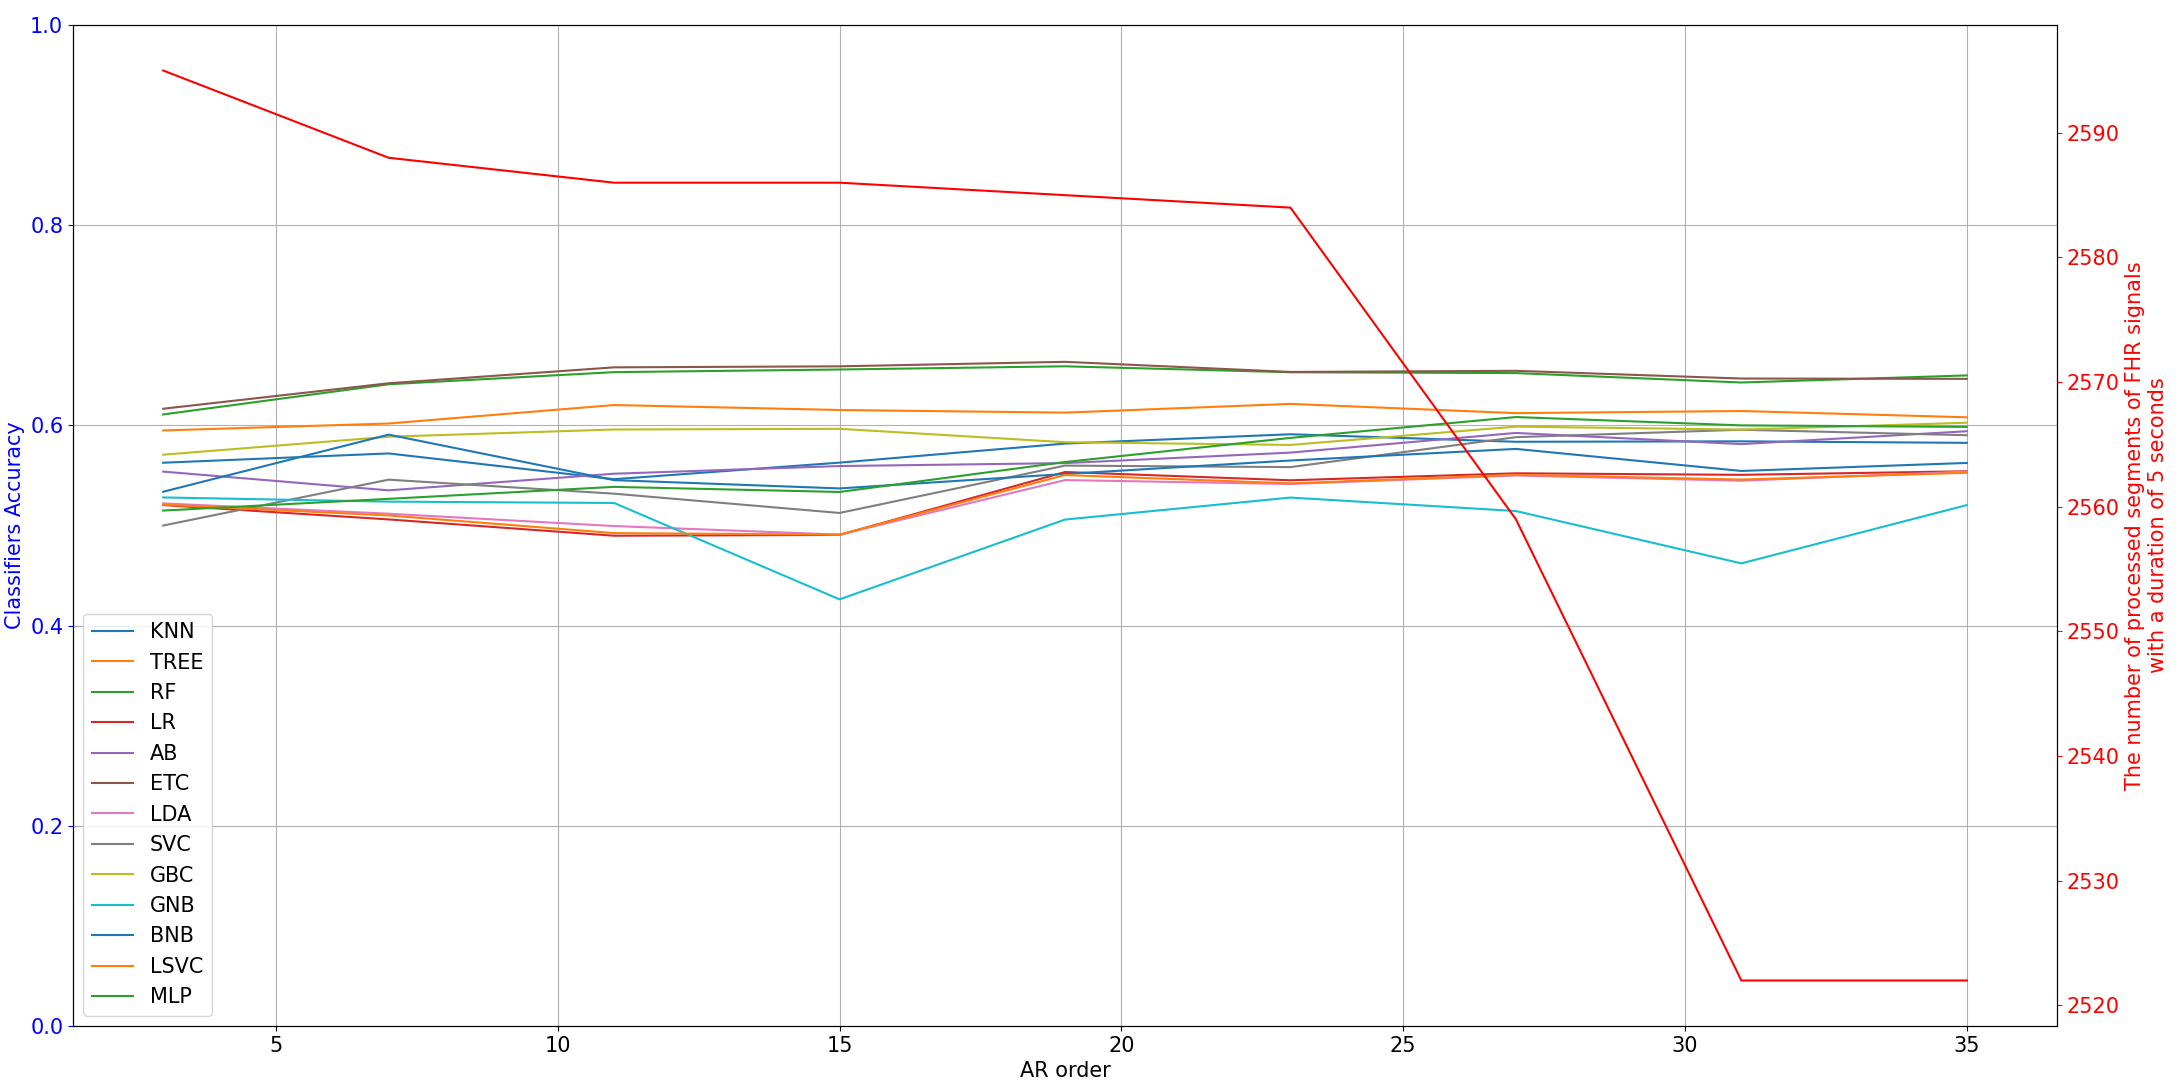

Dependence of the cross-validation coefficient of classifiers and the number of processed segments of FHR signals (sample frequency increased by 5 times)  depending on the order of the autoregressive model

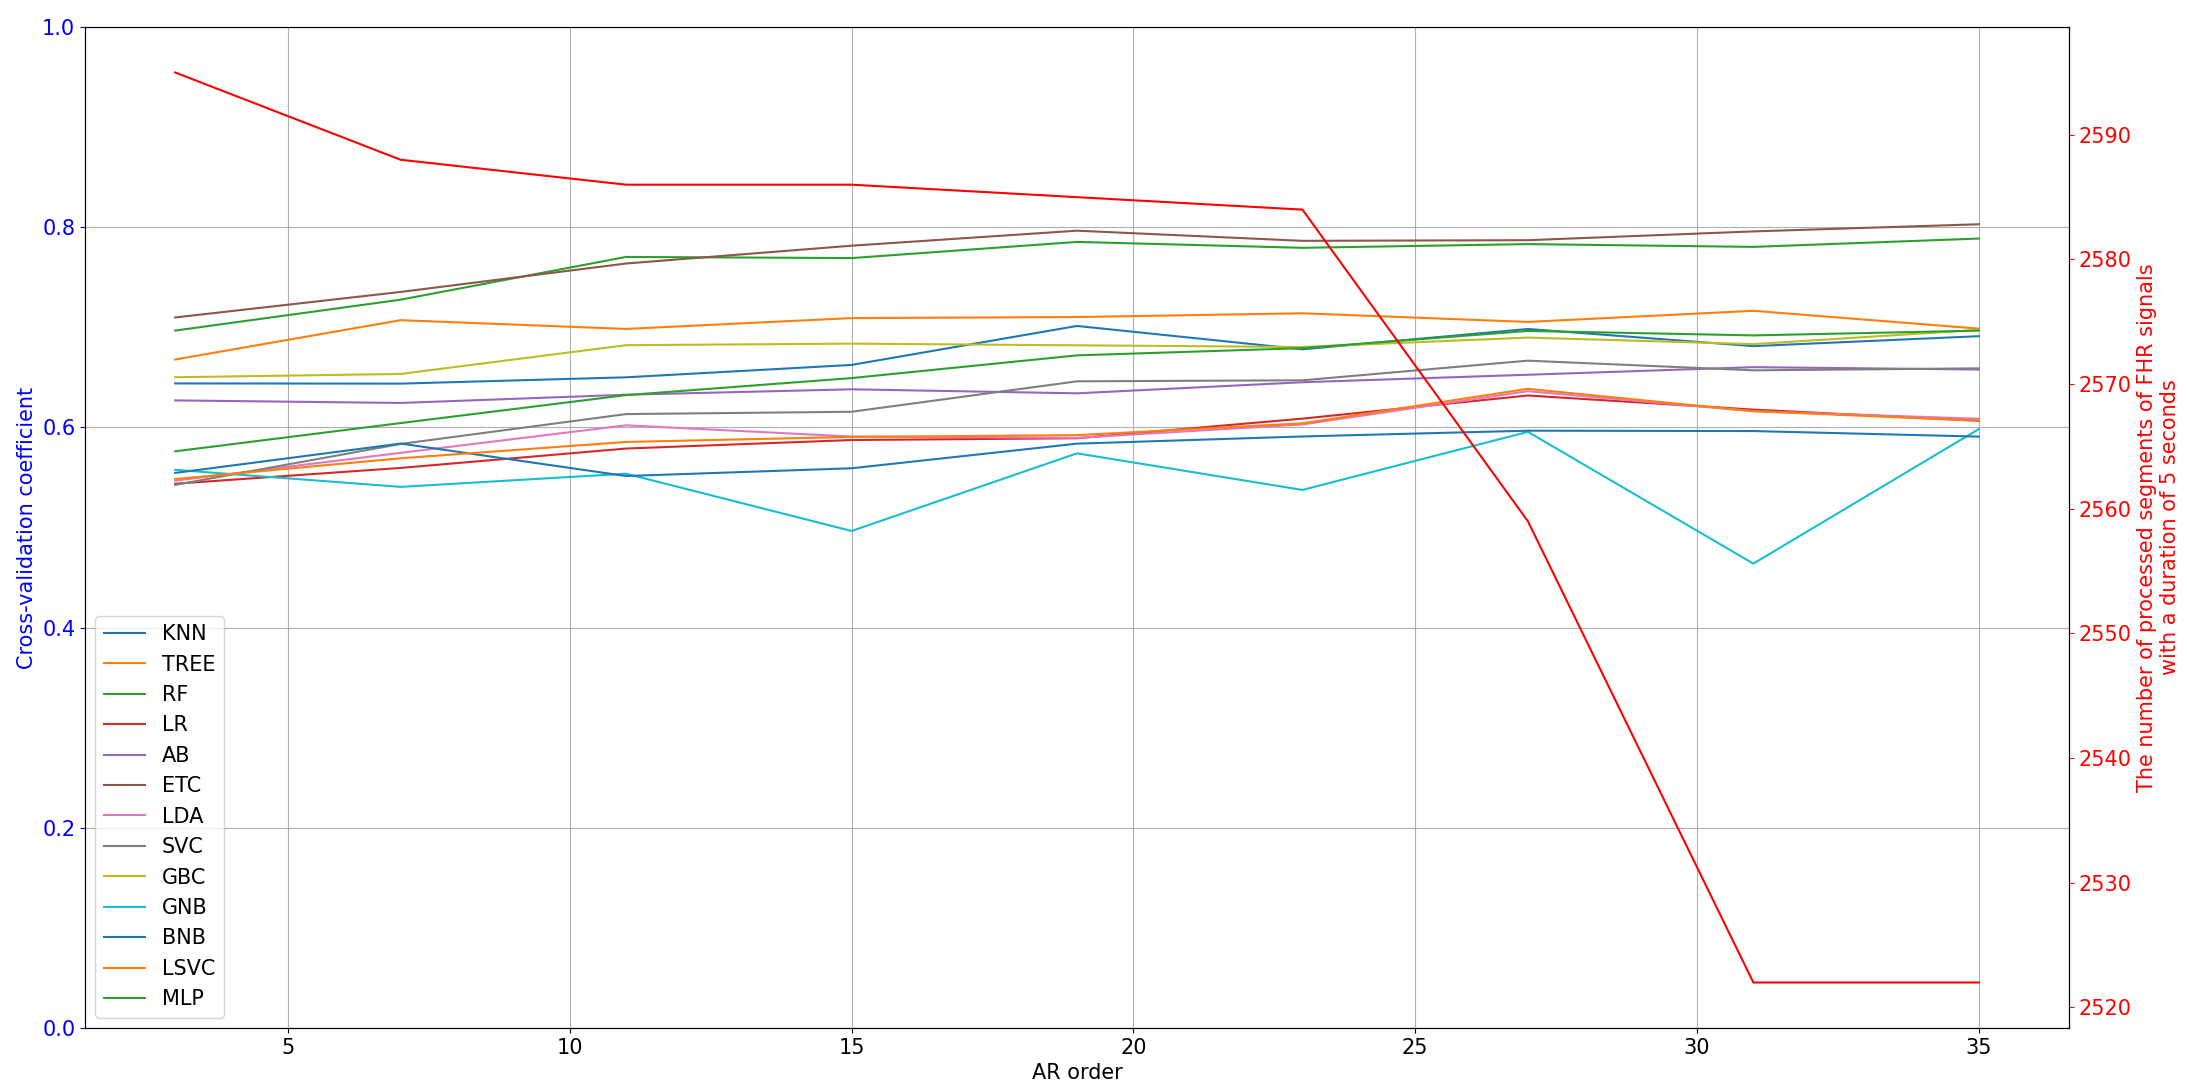

The ExtraTreesClassifier showed the highest accuracy for the order of the autoregressive model "19". But, to improve results, we can use GridSearchCV for the classifier to find parameters with the best accuracy coefficient.

In [ ]:
params = [{'n_estimators': [320, 340, 360, 380, 400],
           'max_depth':    [25, 30, 32, 34, 38, 45],
           'random_state': [0, 1, 2, 42],
           'max_features': ['sqrt', 'log2'],
           'class_weight': ['balanced', 'balanced_subsample']}]
clf = GridSearchCV(ExtraTreesClassifier(), params, scoring='accuracy', n_jobs = -1)
grid_search = clf.fit(X_train, y_train)
print('Best params:', clf.best_params_)
print('Best score:', clf.best_score_)
print('Best index:', clf.best_index_)

As result, we got the next parameters:

*   class_weight = 'balanced'
*   max_depth = 45
*   max_features = 'sqrt'
*   n_estimators = 340
*   random_state = 2

In [ ]:
model = ExtraTreesClassifier(class_weight = 'balanced',
                             max_depth = 45,
                             max_features = 'sqrt',
                             n_estimators = 340,
                             random_state = 2)
model.fit(X_train, y_train)

Confusion matrix for ExtraTreesClassifier with improved parameters

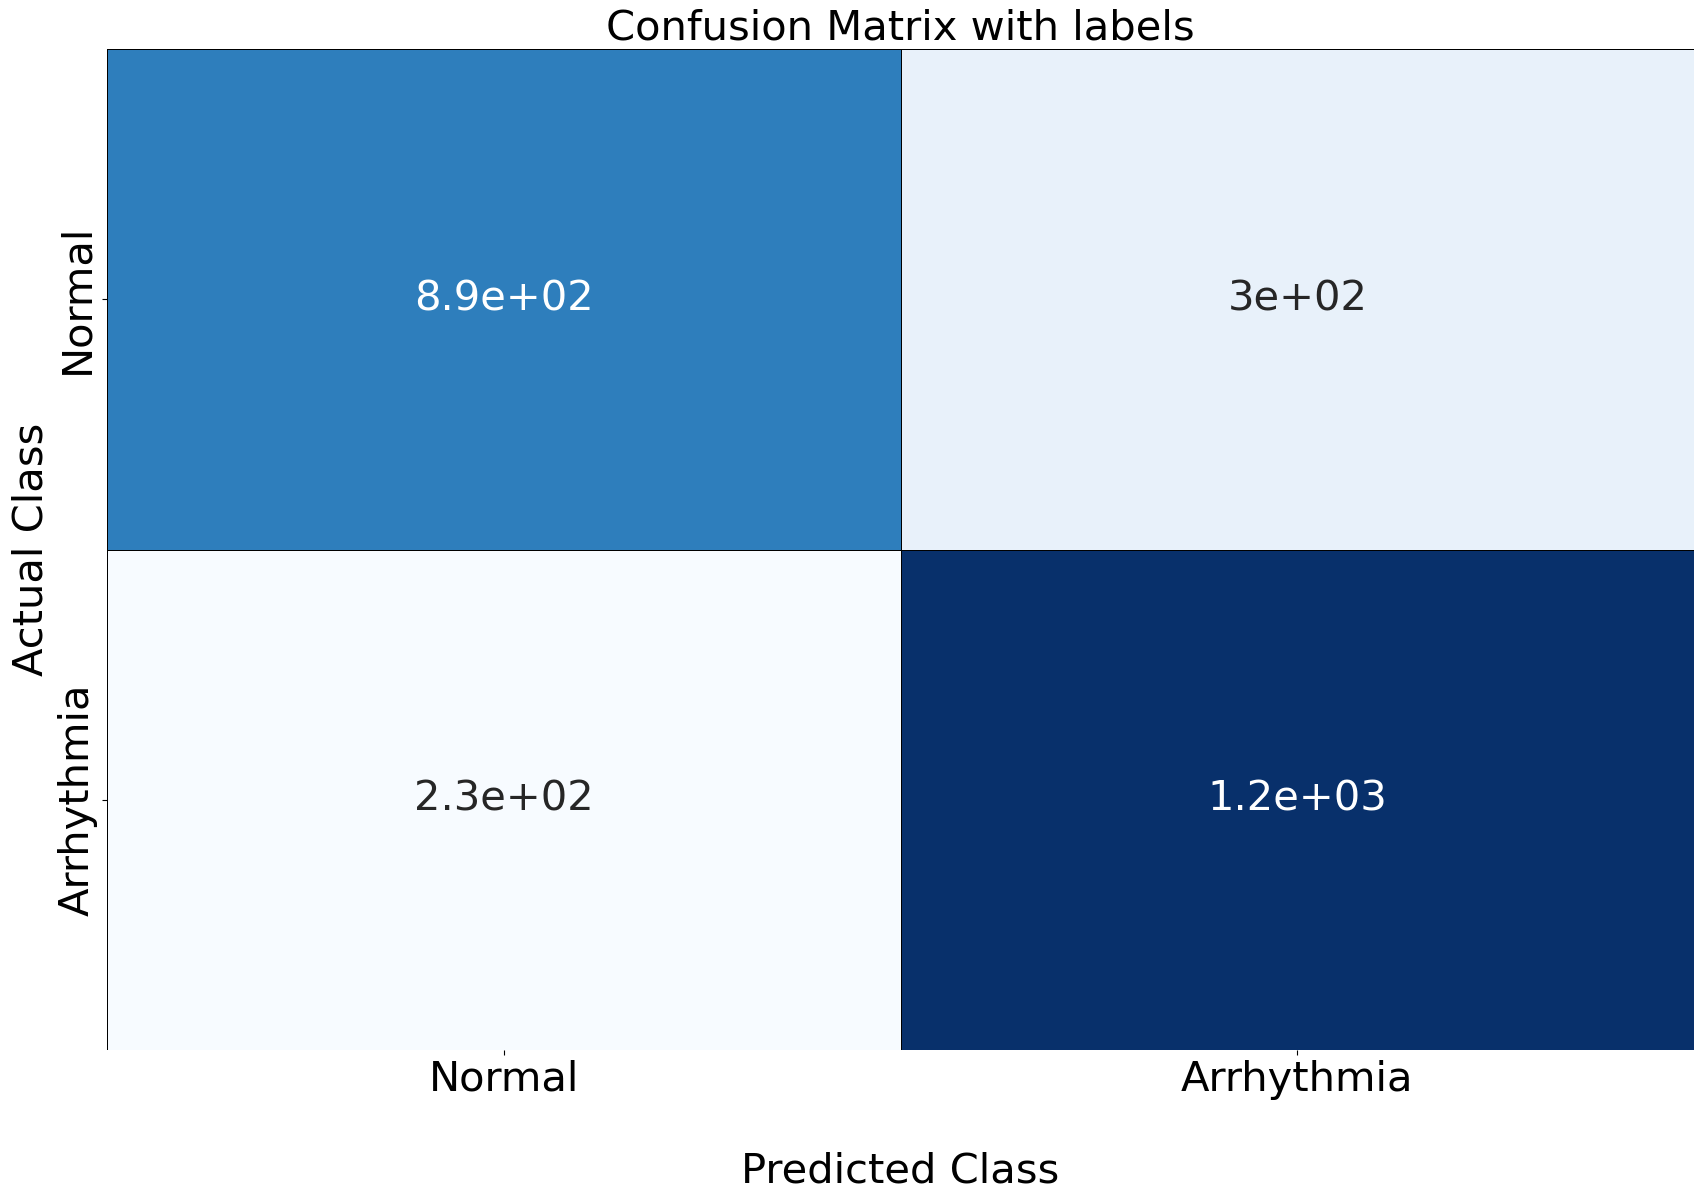

The last step is to test our model using dataset NOT from train \ test databases. Sщ, we will take patient r01 from the database "Abdominal and Direct Fetal ECG Database" (first chapter) with OCNLMS adaptive filter and PCA + FastICA decomposition method. Result will be presenter in the following image.

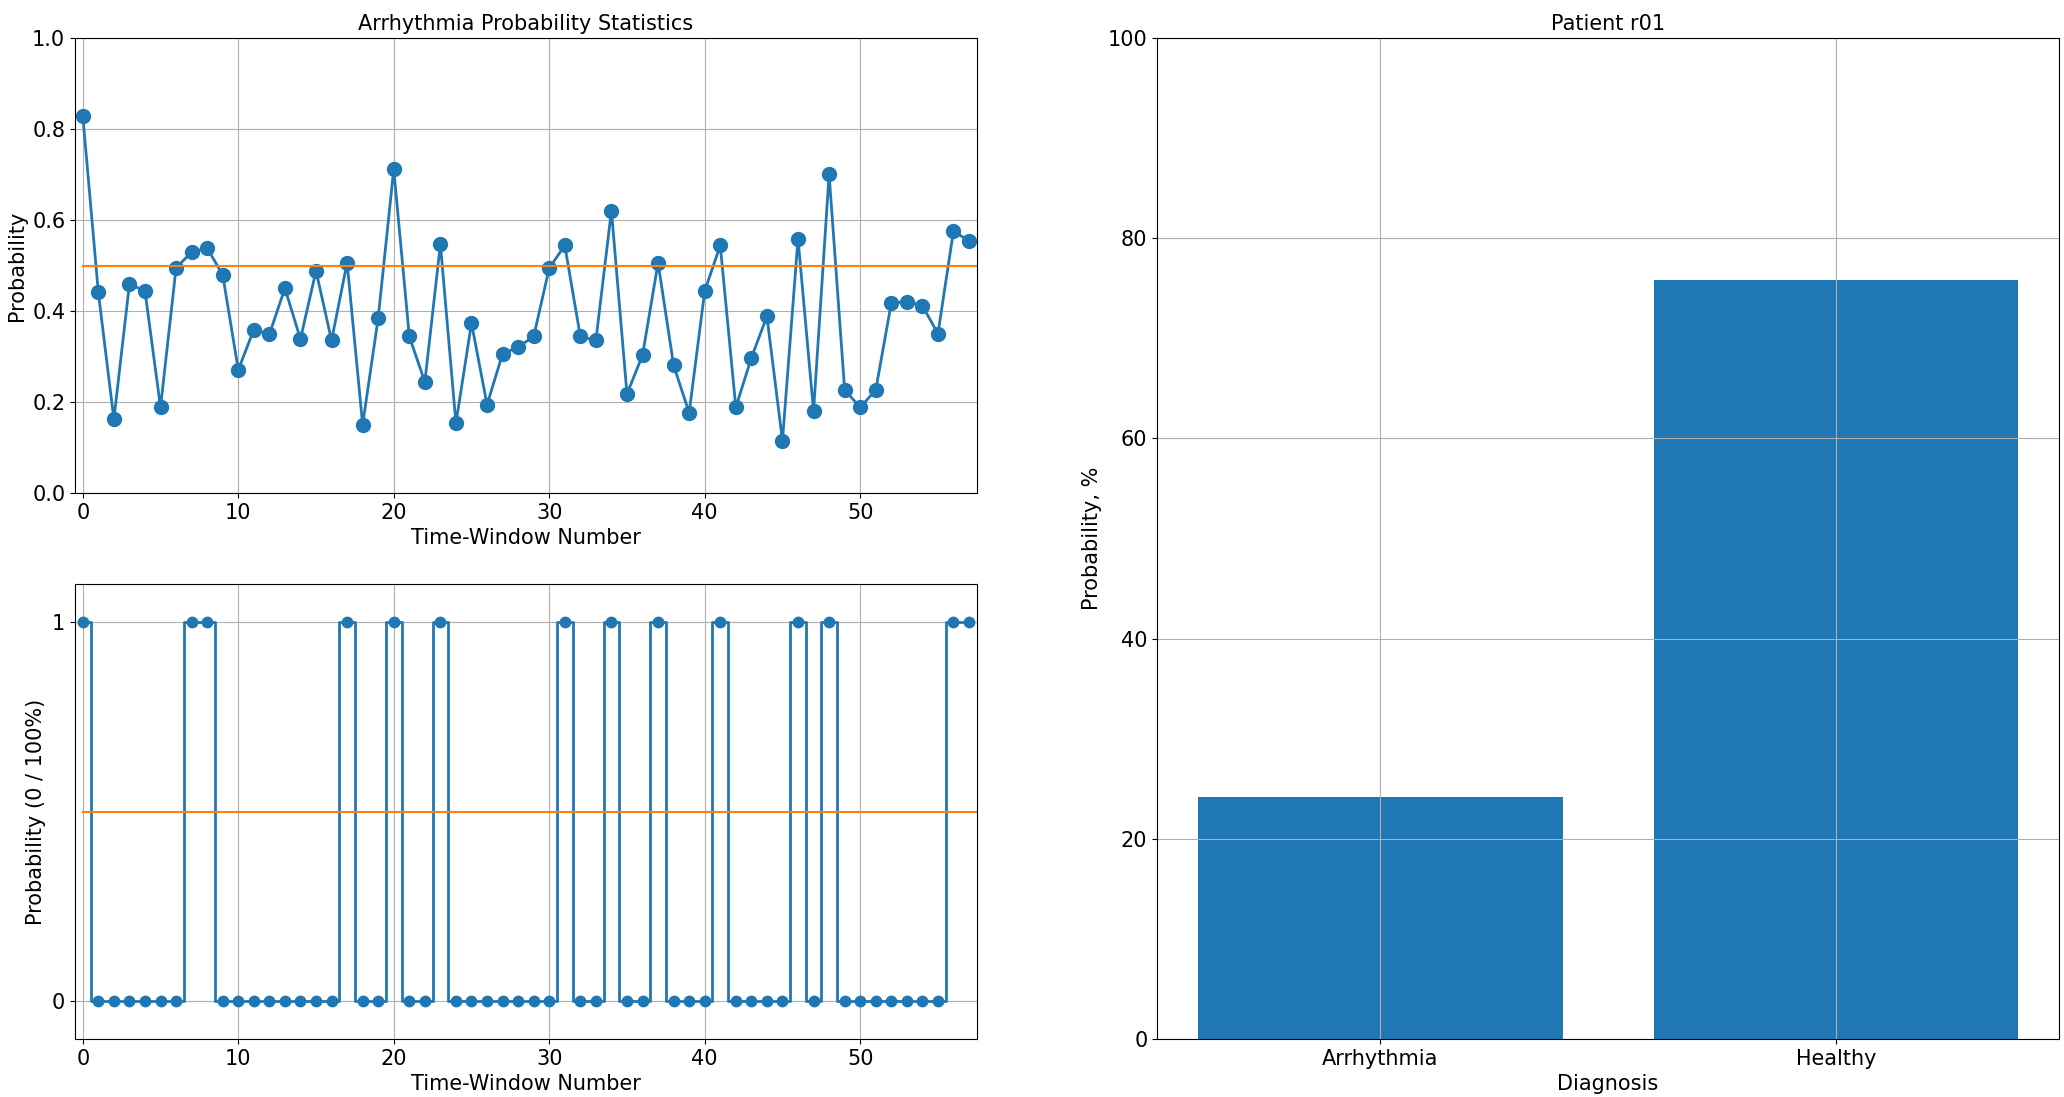

The first image (top left) shows the arrhythmia probability for every time-window segment. The second image (bottom left) shows the same arrhythmia probability for each time-window segment, but rounded to 0 or 100%. And the third image (right) shows general prediction results, that the arrhythmia probability in patient "r01" is 24%.

# Conclusion

The developed method of detecting the fetal ECG signal with the next detection of the probability of arrhythmia showed a classification accuracy of 78.2%. At the stage of extracting the fetal ECG, the adaptive filter and the selection of the correct signal processing algorithm are the main process components.

Analyzing statistical data, it was noted that combinations of algorithms and filters with a Pearson coefficient greater than 0.5 perform was the best. So, it is necessary to choose a set of signal processing method and adaptive filter according to the Pearson coefficient. The signal-to-noise ratio by eigenvalues is also useful, so analysis of the two mentioned coefficients is the most appropriate decision at this stage.

At the stage of analysis of the arrhythmia database, frequency filtering is the main process, since reducing the influence of the maternal component. And finally, the selection of the order and type of the autoregressive model, and the type of classifier were used to create a model for detecting the arrhythmia.


At the end, the developed model was tested on a neutral example that did not participate in training and testing sets. And, as a result, 14 out of 58 checks showed the presence of an arrhythmia, or, in other words, the probability of having an arrhythmia is 24%.